$$\text{\Huge{Heart Disease}}$$
**Dataset:** [Heart Disease Dataset UCI](https://www.kaggle.com/datasets/ketangangal/heart-disease-dataset-uci?select=HeartDiseaseTrain-Test.csv)

$$\text{\Huge{Setup}}$$

In [1]:
import dtreeviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from matplotlib.axes import Axes
from matplotlib.patches import Patch
from matplotlib.projections import register_projection
from sklearn import cluster
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
plt.style.use('science')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlepad'] = 15 
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['legend.title_fontsize'] = 16
plt.rcParams['legend.fontsize'] = 12

In [3]:
CASES = {
    'ecg': 'ECG',
    'max': 'Maximum',
    'min': 'Minimum',
    'sex_female': 'Sex (Female)',
    'sex_male': 'Sex (Male)',
    'chest_pain_type_asymptomatic': 'Chest Pain Type: Asymptomatic',
    'chest_pain_type_atypical_angina': 'Chest Pain Type: Atypical Angina',
    'chest_pain_type_non_anginal_pain': 'Chest Pain Type: Non-Anginal Pain',
    'chest_pain_type_typical_angina': 'Chest Pain Type: Typical Angina',
    'fasting_blood_sugar_greater_than_120_mg_ml': 'Fasting Blood Sugar (Greater Than 120 mg/ml)',
    'fasting_blood_sugar_lower_than_120_mg_ml': 'Fasting Blood Sugar (Lower Than 120 mg/ml)',
    'rest_ecg_left_ventricular_hypertrophy': 'Rest ECG: Left Ventricular Hypertrophy',
    'rest_ecg_normal': 'Rest ECG: Normal',
    'rest_ecg_st_t_wave_abnormality': 'Rest ECG: ST-T Wave Abnormality',
    'exercise_induced_angina_no': 'Exercise Induced Angina: No',
    'exercise_induced_angina_yes': 'Exercise Induced Angina: Yes',
    'slope_downsloping': 'Slope: Downsloping',
    'slope_flat': 'Slope: Flat',
    'slope_upsloping': 'Slope: Upsloping',
    'thalassemia_fixed_defect': 'Thalassemia: Fixed Defect',
    'thalassemia_no': 'Thalassemia: No',
    'thalassemia_normal': 'Thalassemia: Normal',
    'thalassemia_reversable_defect': 'Thalassemia: Reversible Defect',
    'age': 'Age',
    'resting_blood_pressure': 'Resting Blood Pressure',
    'cholesterol': 'Cholesterol',
    'max_heart_rate': 'Maximum Heart Rate',
    'old_peak': 'Old Peak',
    'param_C': 'Parameters (C)',
    'param_min_samples_split': 'Parameters (Minimum Samples Split)',
    'param_max_depth': 'Parameters (Maximum Depth)',
    'param': '',
    'mean_train_score': 'Mean Train Score'
}

def column_to_title(column: str) ->  str:
    if column in CASES:
        return CASES[column]
    
    for word, replacement in CASES.items():
        if word in column.split('_'):
            return replacement

    return column.replace('_', ' ').title()

In [4]:
def update_label(labels: list[str]) -> list[str]:
    y = []
    
    for label in labels:
        text = label.get_text()
        label = column_to_title(text)
        
        y.append(label)

    return y

In [5]:
def display_score(test, prediction, **kwargs):
    accuracy = accuracy_score(
        test,
        prediction
    )

    precision = precision_score(
        test,
        prediction,
        **kwargs
    )

    recall = recall_score(
        test,
        prediction,
        **kwargs
    )

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")


def display_confusion_matrix(test, prediction, **kwargs):
    figsize = (8, 8)
    fig, ax = plt.subplots(figsize=figsize)

    cm = confusion_matrix(test, prediction)

    heatmap = sns.heatmap(
        cm, 
        annot=True,
        annot_kws={'size': 16},
        square=True, 
        fmt='.0f'
    )
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    ax.tick_params(axis='both', which='both', length=0)

    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(length=0)  

    plt.show()
    plt.close()


def display_permutation_importance(data: pd.DataFrame, name: str | None = None) -> None:
    figsize = (18, 9)
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.barplot(
        data=data,
        y='variable',
        x='importance',
        hue='variable',
        palette='hls',
        legend=False
    )
    
    ax.tick_params(axis='y', which='both', left=False, right=False)
    
    ax.set_xlabel('Importance')
    ax.set_ylabel('Variable')
    
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    yticklabels = update_label(yticklabels)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    title = f"Permutation Importance for {name}"
    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def plot_numerical(data, numerical):
    for index, x in enumerate(numerical, 0):
        figsize = (16, 6)
        fig, ax = plt.subplots(figsize=figsize)

        if index % 2 == 0:
            palette = 'rocket'
        else:
            palette = 'mako'

        y = 'target'

        sns.scatterplot(
            data=data,
            x=x,
            y=y,
            hue=y,
            palette=palette,
            s=150,
            alpha=0.25
        )

        y = ax.yaxis.get_label().get_text()
        x = column_to_title(x)
        y = column_to_title(y)

        ax.set_xlabel(x)
        ax.set_ylabel(y)

        handles, labels = ax.get_legend_handles_labels()
        
        labels = [
            'No Heart Disease' 
            if label == '0'
            else 'Heart Disease' 
            for label in labels
        ]
        
        ax.legend(
            handles, 
            labels, 
            title='Target', 
            loc='upper left', 
            bbox_to_anchor=(1, 1)
        )

        ax.set_title('Heart Disease vs. ' + x)

        plt.tight_layout()
        plt.show()
        plt.close()
        
        print('\n')


def plot_categorical(data, categorical):
    for index, x in enumerate(categorical, 0):
        figsize = (16, 6)
        fig, ax = plt.subplots(figsize=figsize)

        if index % 2 == 0:
            palette = 'rocket'
        else:
            palette = 'mako'

        hue = 'target'

        sns.countplot(
            data=data,
            x=x,
            hue=hue,
            palette=palette
        )

        y = ax.yaxis.get_label().get_text()

        x = column_to_title(x)
        y = column_to_title(y)

        ax.set_xlabel(x)
        ax.set_ylabel(y)

        handles, labels = ax.get_legend_handles_labels()
        
        labels = [
            'No Heart Disease' 
            if label == '0'
            else 'Heart Disease' 
            for label in labels
        ]
        
        ax.legend(
            handles, 
            labels, 
            title='Target', 
            loc='upper left', 
            bbox_to_anchor=(1, 1)
        )

        ax.set_title('Heart Disease vs. ' + x)

        plt.tight_layout()
        plt.show()
        plt.close()
        
        print('\n')

$$\text{\Huge{Data understanding}}$$

I have changed the following column(s) for the sake of convention:

* cholestoral $\rightarrow$ cholesterol

* Max_heart_rate $\rightarrow$ max_heart_rate

* oldpeak $\rightarrow$ old_peak

* vessels_colored_by_flourosopy $\rightarrow$ vessels_colored_by_flouroscopy

In [7]:
dtype = {
    'age': 'int8',
    'sex': 'category',
    'chest_pain_type': 'category',
    'resting_blood_pressure': 'int16',
    'cholesterol': 'int16',
    'fasting_blood_sugar': 'category',
    'rest_ecg': 'category',
    'max_heart_rate': 'int16',
    'exercise_induced_angina': 'object',
    'old_peak': 'float16',
    'slope': 'category',
    'vessels_colored_by_flouroscopy': 'category',
    'thalassemia': 'category',
    'target': 'int8',
}

usecols = [
    'age',
    'sex',
    'chest_pain_type',
    'resting_blood_pressure',
    'cholestoral',
    'fasting_blood_sugar',
    'rest_ecg',
    'Max_heart_rate',
    'exercise_induced_angina',
    'oldpeak',
    'slope',
    'vessels_colored_by_flourosopy',
    'thalassemia',
    'target'
]

df_heart = pd.read_csv(
    'dataset/heart.csv',
    engine='python',
    dtype=dtype,
    usecols=usecols
)

columns = {
    'cholestoral': 'cholesterol', 
    'Max_heart_rate': 'max_heart_rate', 
    'vessels_colored_by_flourosopy': 'vessels_colored_by_flouroscopy', 
    'oldpeak': 'old_peak'
}

df_heart = df_heart.rename(columns=columns)

In [8]:
df_heart.shape

(1025, 14)

In [9]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   age                             1025 non-null   int8    
 1   sex                             1025 non-null   category
 2   chest_pain_type                 1025 non-null   category
 3   resting_blood_pressure          1025 non-null   int16   
 4   cholesterol                     1025 non-null   int64   
 5   fasting_blood_sugar             1025 non-null   category
 6   rest_ecg                        1025 non-null   category
 7   max_heart_rate                  1025 non-null   int64   
 8   exercise_induced_angina         1025 non-null   object  
 9   old_peak                        1025 non-null   float64 
 10  slope                           1025 non-null   category
 11  vessels_colored_by_flouroscopy  1025 non-null   object  
 12  thalassemia         

In [10]:
df_heart.head(5)

age     sex chest_pain_type  resting_blood_pressure  cholesterol  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  old_peak        slope  \
0                      No       1.0  Downsloping   
1                     Yes       3.1    Upsloping   
2                     Yes       2.6    Upsloping   
3                      No       0.0  Downsloping   
4                      No       1.9         Flat   

  vessels_colored_by_flouroscopy        thalassemia  target  
0                            Two  Reversable Defect       0  
1                           Zero  Reversable Defect       0  
2                           Zero  Reversable Defect       0  
3                            One  Reversable Defect       0  
4                          Three       Fixed Defect       0

In [11]:
df_heart.isna().sum()

age                               0
sex                               0
chest_pain_type                   0
resting_blood_pressure            0
cholesterol                       0
fasting_blood_sugar               0
rest_ecg                          0
max_heart_rate                    0
exercise_induced_angina           0
old_peak                          0
slope                             0
vessels_colored_by_flouroscopy    0
thalassemia                       0
target                            0
dtype: int64

In [12]:
df_heart.describe()

age  resting_blood_pressure  cholesterol  max_heart_rate  \
count  1025.000000             1025.000000   1025.00000     1025.000000   
mean     54.434146              131.611707    246.00000      149.114146   
std       9.072290               17.516718     51.59251       23.005724   
min      29.000000               94.000000    126.00000       71.000000   
25%      48.000000              120.000000    211.00000      132.000000   
50%      56.000000              130.000000    240.00000      152.000000   
75%      61.000000              140.000000    275.00000      166.000000   
max      77.000000              200.000000    564.00000      202.000000   

          old_peak       target  
count  1025.000000  1025.000000  
mean      1.071512     0.513171  
std       1.175053     0.500070  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.800000     1.000000  
75%       1.800000     1.000000  
max       6.200000     1.000000

$$\text{\Huge{Data exploration and visualization}}$$

In [13]:
df_male = df_heart[df_heart['sex'] == 'Male']
df_female = df_heart[df_heart['sex'] == 'Female']
df_male_hd = df_male[df_male.target == 1]
df_female_hd = df_female[df_female.target == 1]

total_male = df_male.sex.count()
total_female = df_female.sex.count()

total_male_hd = df_male_hd.target.count()
total_female_hd = df_female_hd.target.count()

print(f"{total_male_hd}/{total_male} males had heart disease")
print(f"{total_female_hd}/{total_female} females had heart disease")

300/713 males had heart disease
226/312 females had heart disease


In [14]:
categorical = df_heart.select_dtypes(['category', 'object']).columns.tolist()
numerical = df_heart.drop('target', axis=1).select_dtypes('number').columns.tolist()

I have no personal experience or knowledge on the diagnosis on heart disease, which made it challenging to grasp the data. I was also unfamiliar with most the terms in the dataset, which required additional research. As a result, I'm not as confident in my interpretation as I had hoped.


I was surprised by the lack of information and correlation from the numerical data. I predicted that variables such as age, cholesterol or maximum heart rate would have a more profound effect on heart disease. However, it seemed to have no bearing from a visualization perspective. In my mind, most of the numeric variables seemed easier to associate with heart disease.


The categorical variables seemed to have more weight on the diagnosis of heart disease, and it was easier to distinguish which groups of being were more affected by it. However, the categorical data introduced new concepts to me, which made it more difficult to understand the data without further research. It would be ideal to talk to a professional about the diagnosis of heart disease, which would give me a better feel for it.

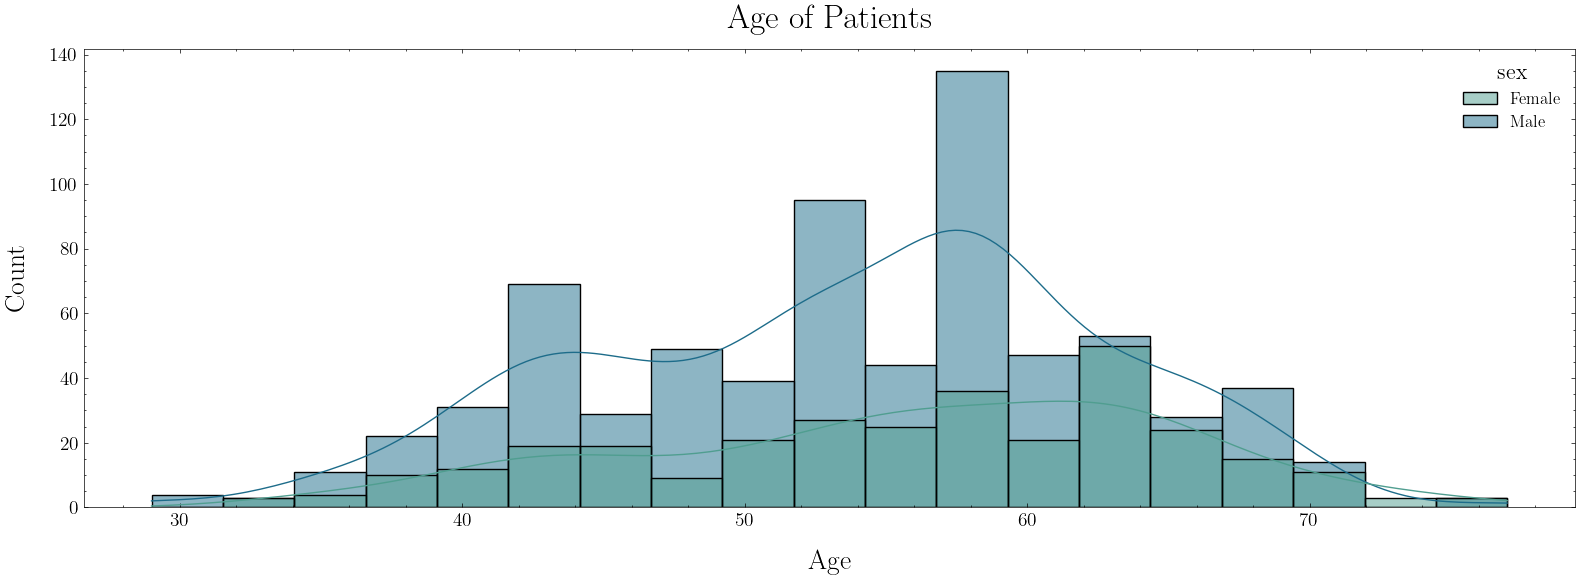

In [15]:
figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

x = 'age'

sns.histplot(
    data=df_heart,
    x='age',
    hue='sex',
    kde=True,
    palette='crest'
)

x = column_to_title(x)
ax.set_xlabel(x)

ax.set_title('Age of Patients')

plt.tight_layout()
plt.show()
plt.close()

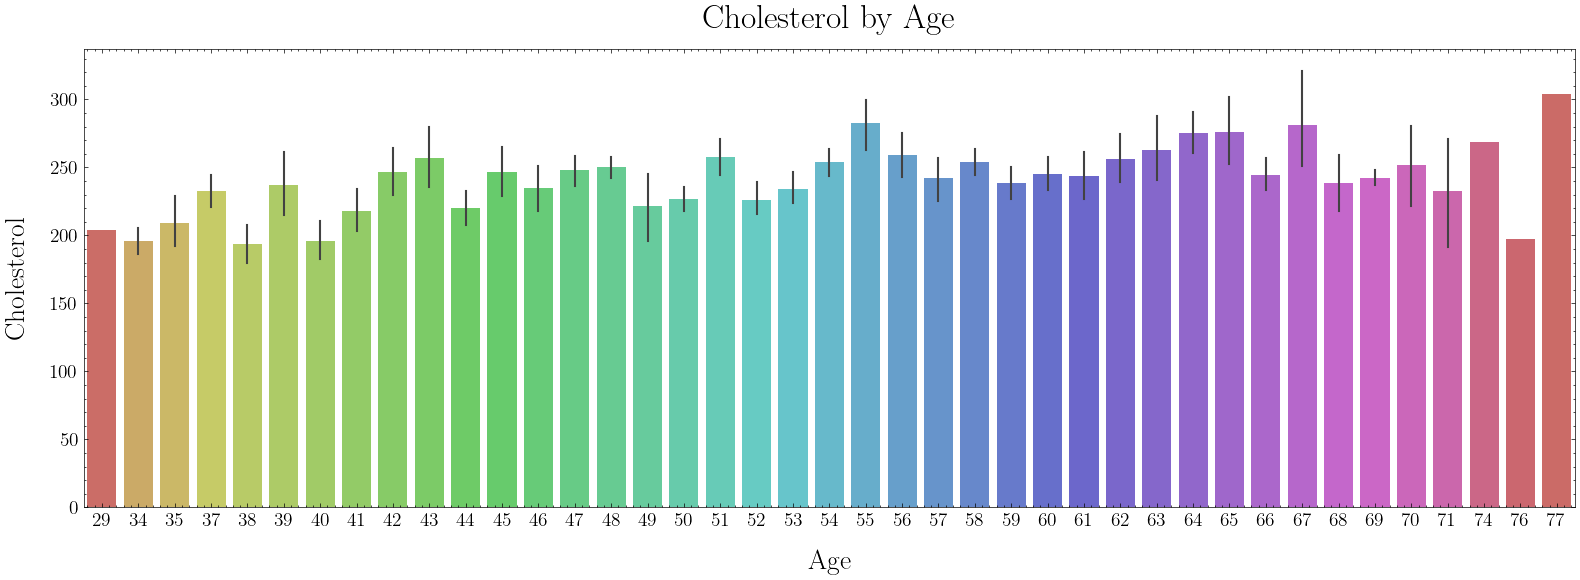

In [16]:
figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

x = 'age'
y = 'cholesterol'

sns.barplot(
    data=df_heart,
    x=x,
    y=y,
    orient='v',
    hue=x,
    legend=False,
    palette='hls'
)

x = column_to_title(x)
y = column_to_title(y)

ax.set_xlabel(x)
ax.set_ylabel(y)

ax.set_title('Cholesterol by Age')

plt.tight_layout()
plt.show()
plt.close()

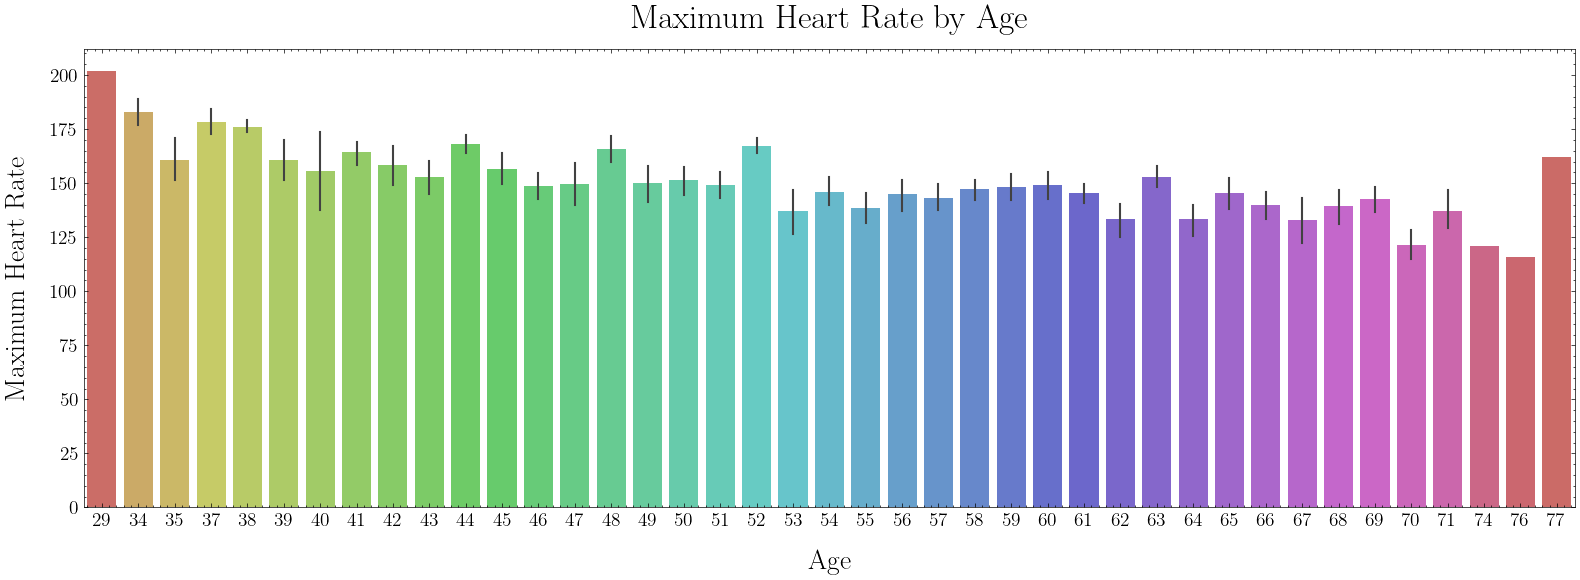

In [17]:
figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

x = 'age'
y = 'max_heart_rate'

sns.barplot(
    data=df_heart,
    x=x,
    y=y,
    orient='v',
    hue=x,
    legend=False,
    palette='hls'
)

x = column_to_title(x)
y = column_to_title(y)

ax.set_xlabel(x)
ax.set_ylabel(y)

ax.set_title('Maximum Heart Rate by Age')

plt.tight_layout()
plt.show()
plt.close()

The mean for maximum heart rate was 149.11 BPM, and there was an upswing of people who had heart disease at ~130 BPM and above. There were also more people who had heart disease at ~170 BPM and above. The cutoff for people without heart disease is below ~180 BPM, excluding some outliers.

The old peak variable seemed telling of heart disease, which is described as the "*ST depression induced by exercise relative to rest*" (**Source:** [NCBI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5863635/)). 

People who had disease seemed to score around the ~0-2 range, whereas those who did not ranged from ~0-4, and as far as 6.

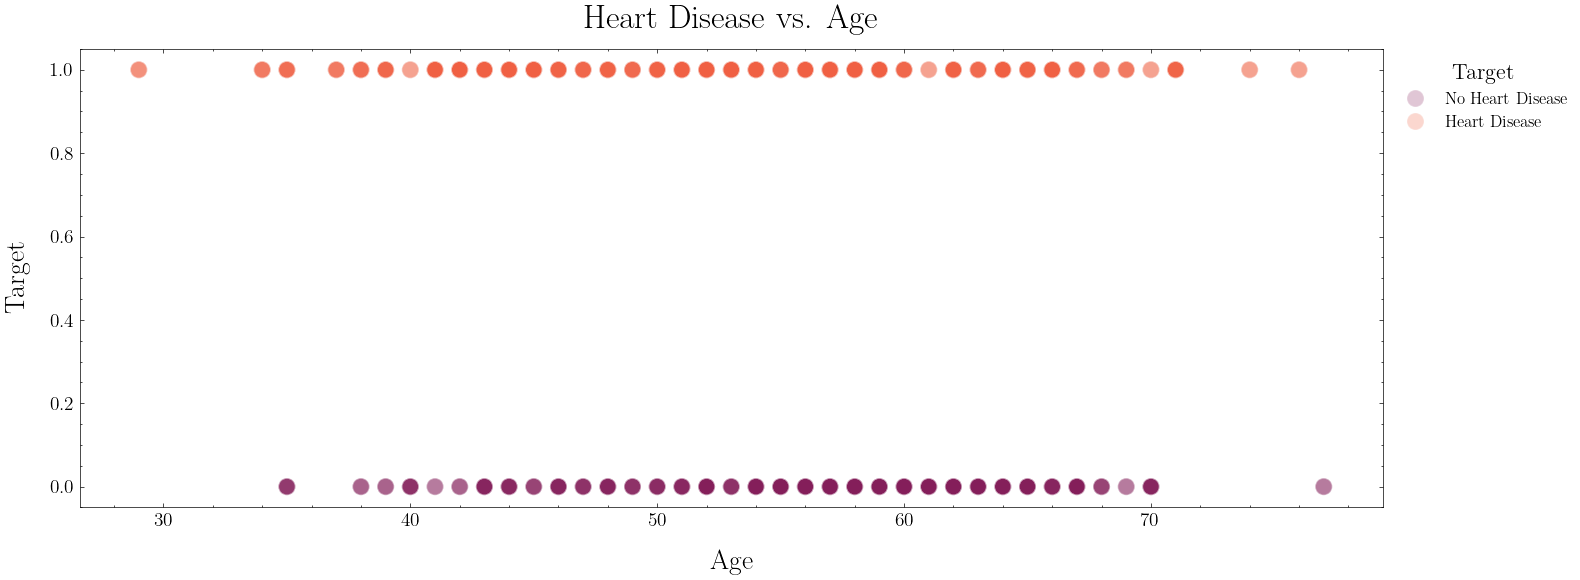

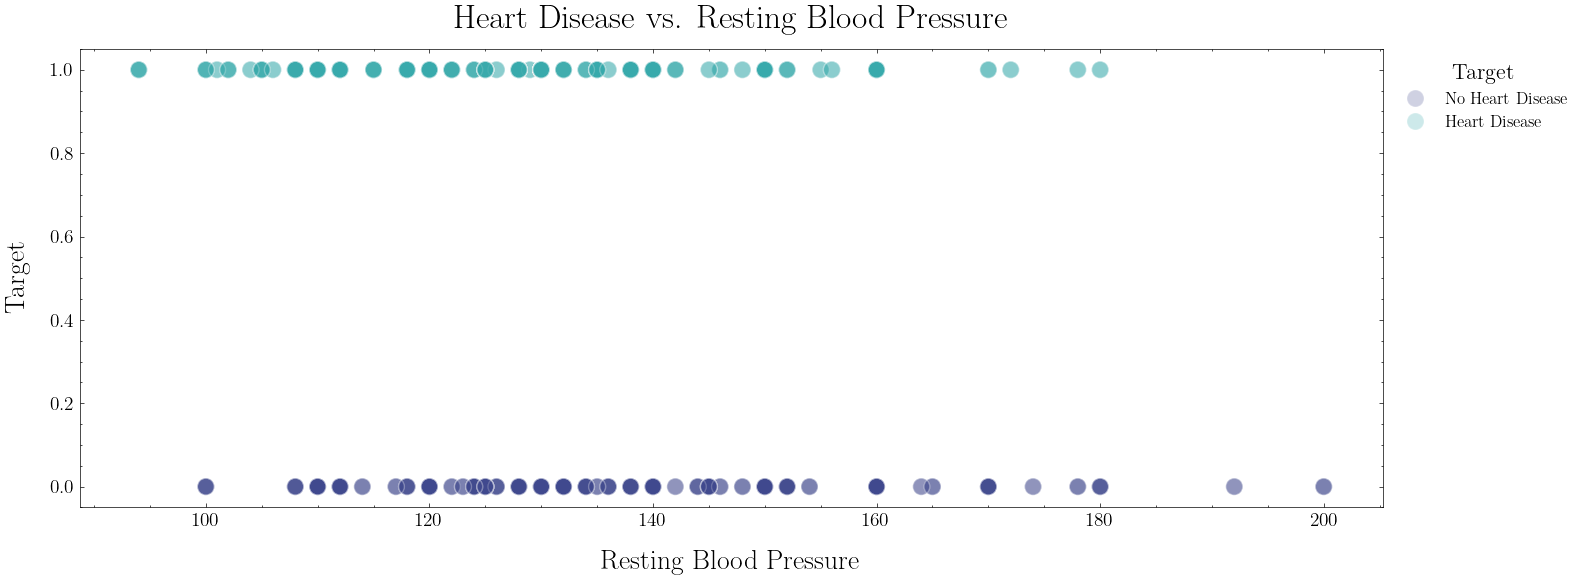

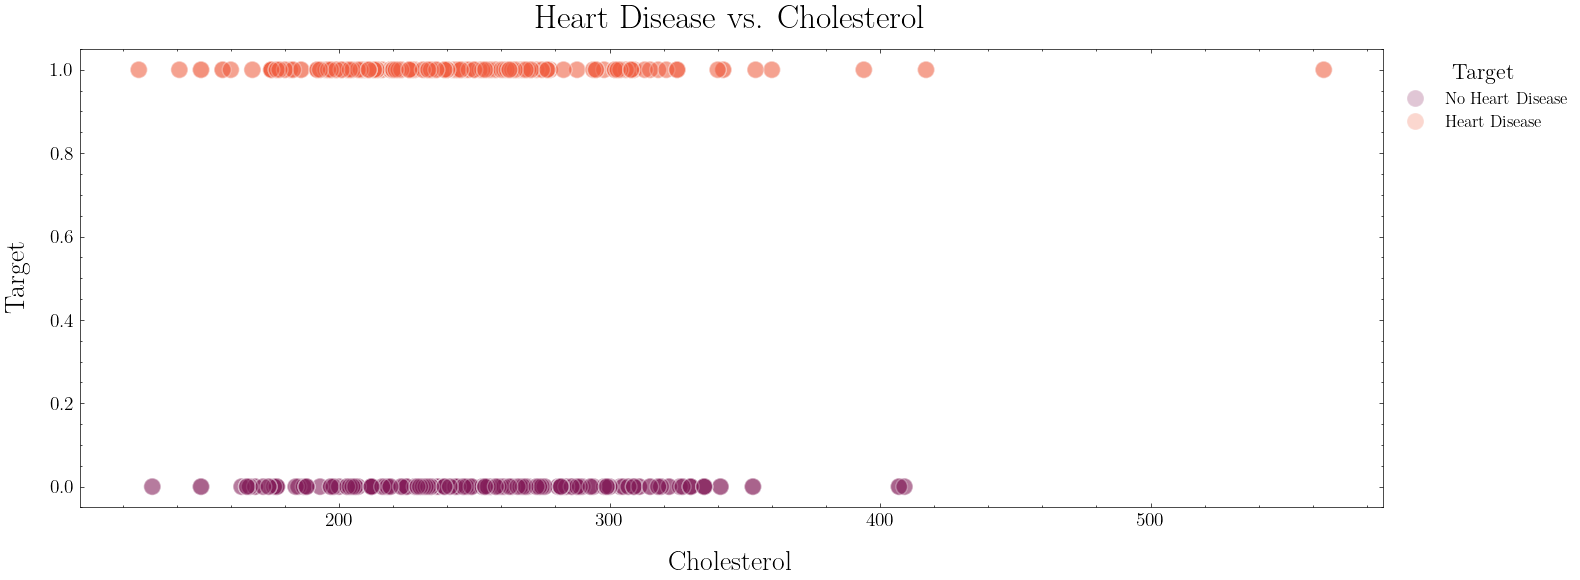

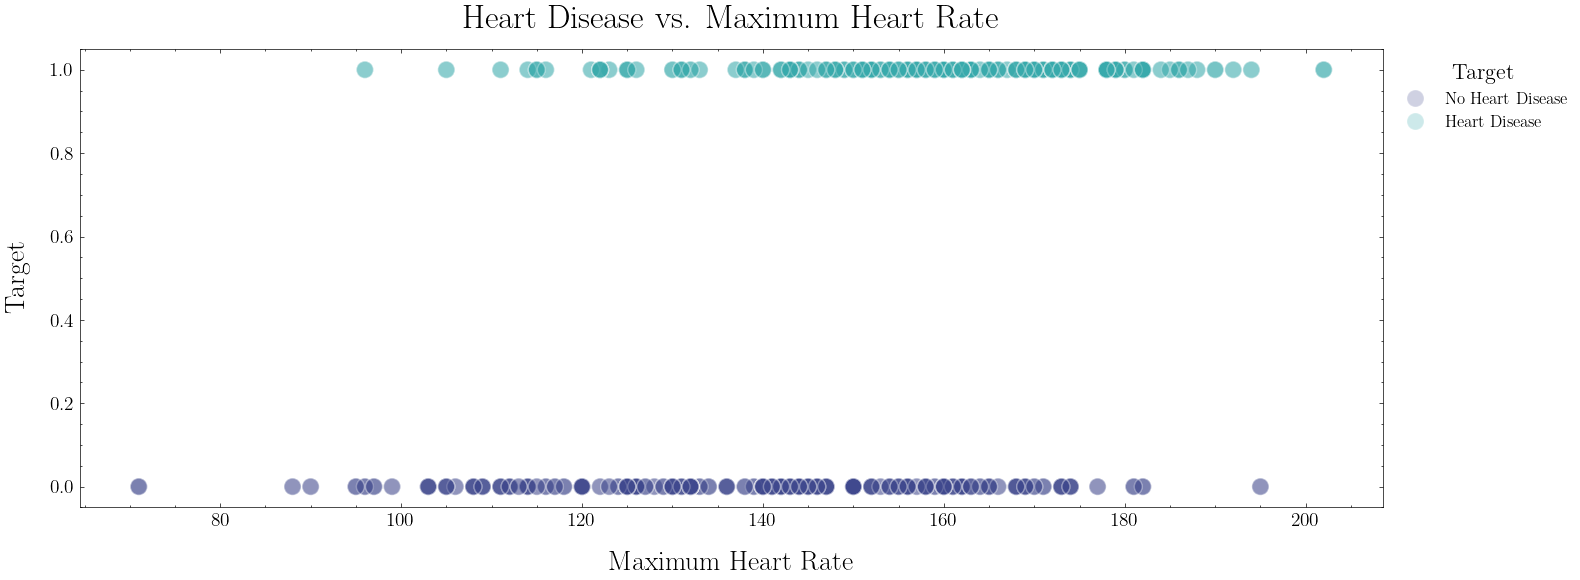

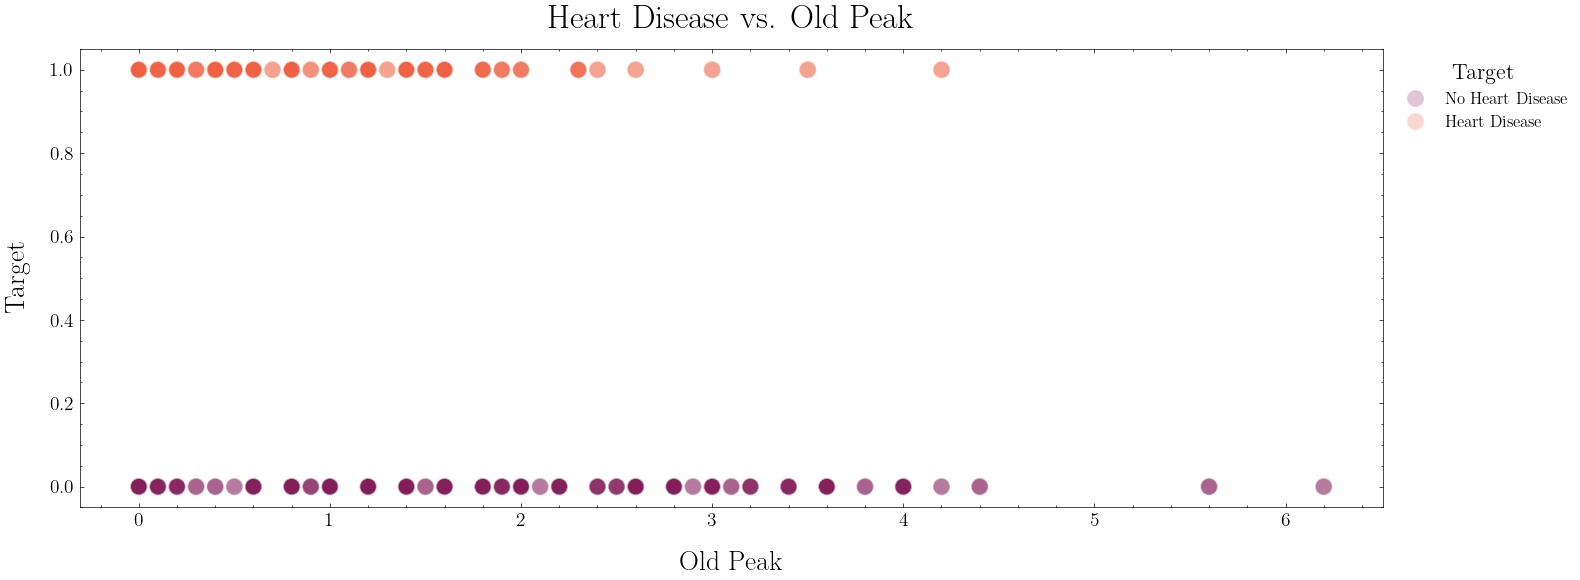

In [18]:
plot_numerical(df_heart, numerical)

The most dominant variables according to categorical visualization:
*   **Sex:** Female
    *   In total, there were 1025 rows in the dataset...
        *   Females made up 30.44% of the dataset, but on average seemed to suffer far more from heart disease than males.
        *   300/713 (42.10%) males had heart disease.
        *   226/312 (72.44%) females had heart disease.
        *   This information was explored in this [cell](https://colab.research.google.com/drive/1BHq32AvYGvSPL55FgauE4KzphHDnF3XX#scrollTo=nx2uSCoQYg-5&line=13&uniqifier=1) above.
*   **Chest Pain Type:** Non-anginal pain
*   **Fasting Blood Sugar:** Lower than 120 mg/ml
*   **Resting ECG:** ST-T wave abnormality
*   **Exercise Induced Angina:** No
*   **Slope:** Downsloping
*   **Vessels Colored by Flourosopy:** Zero
*   **Thalassemia**: Fixed Defect

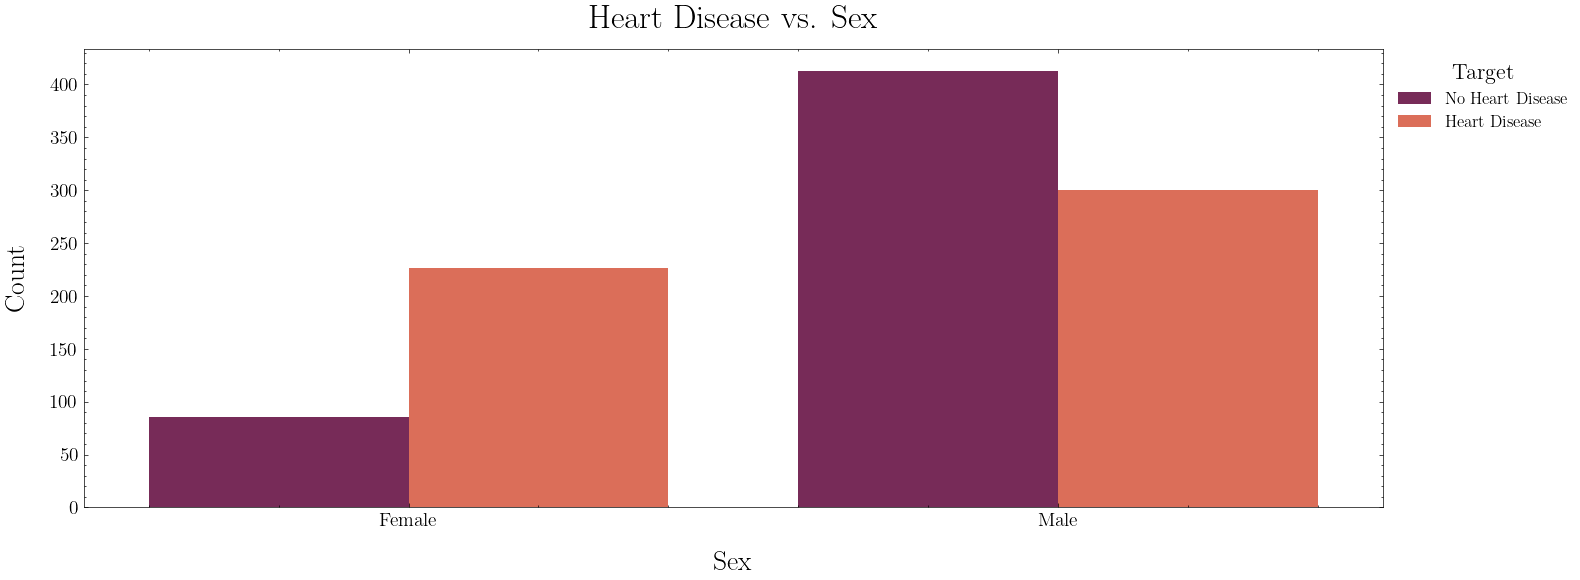

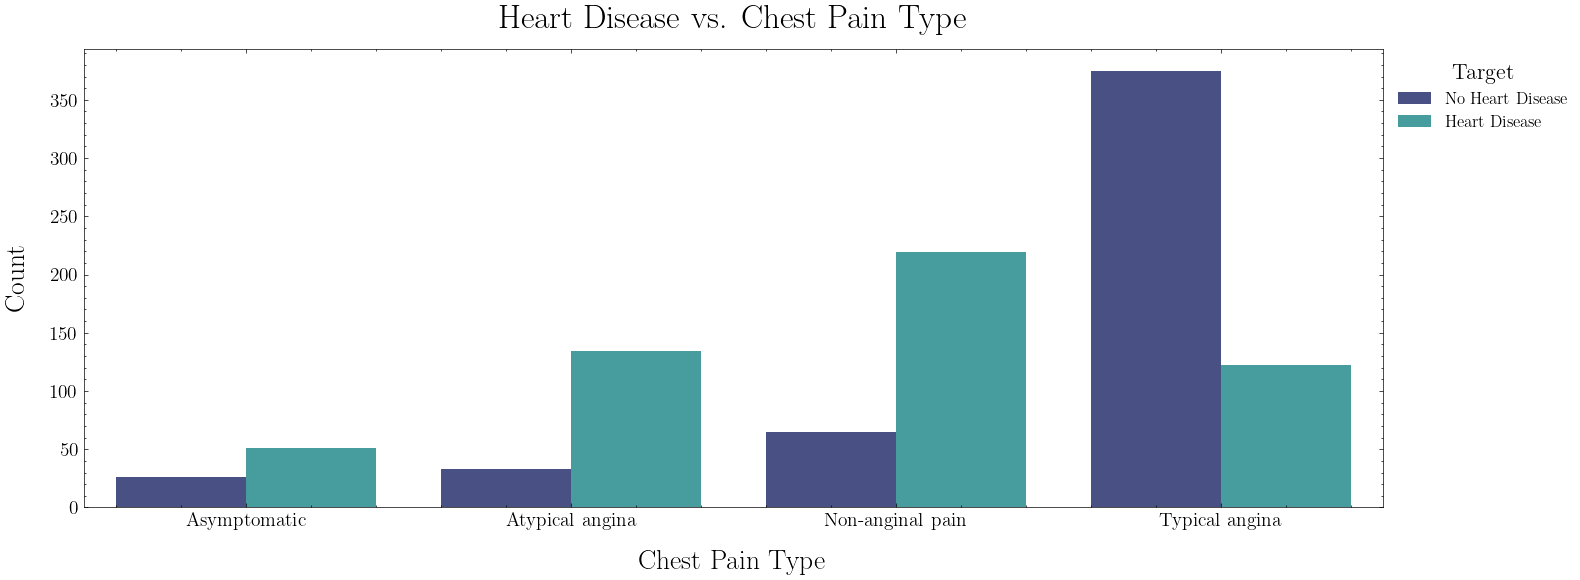

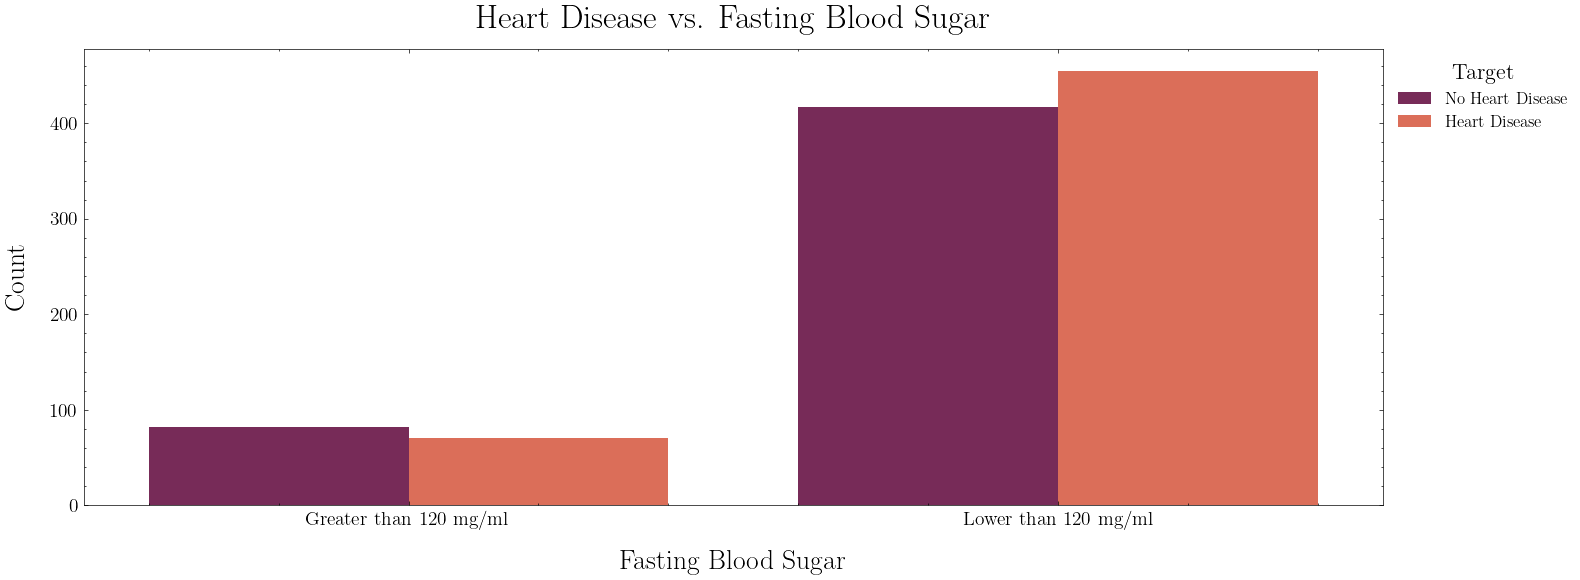

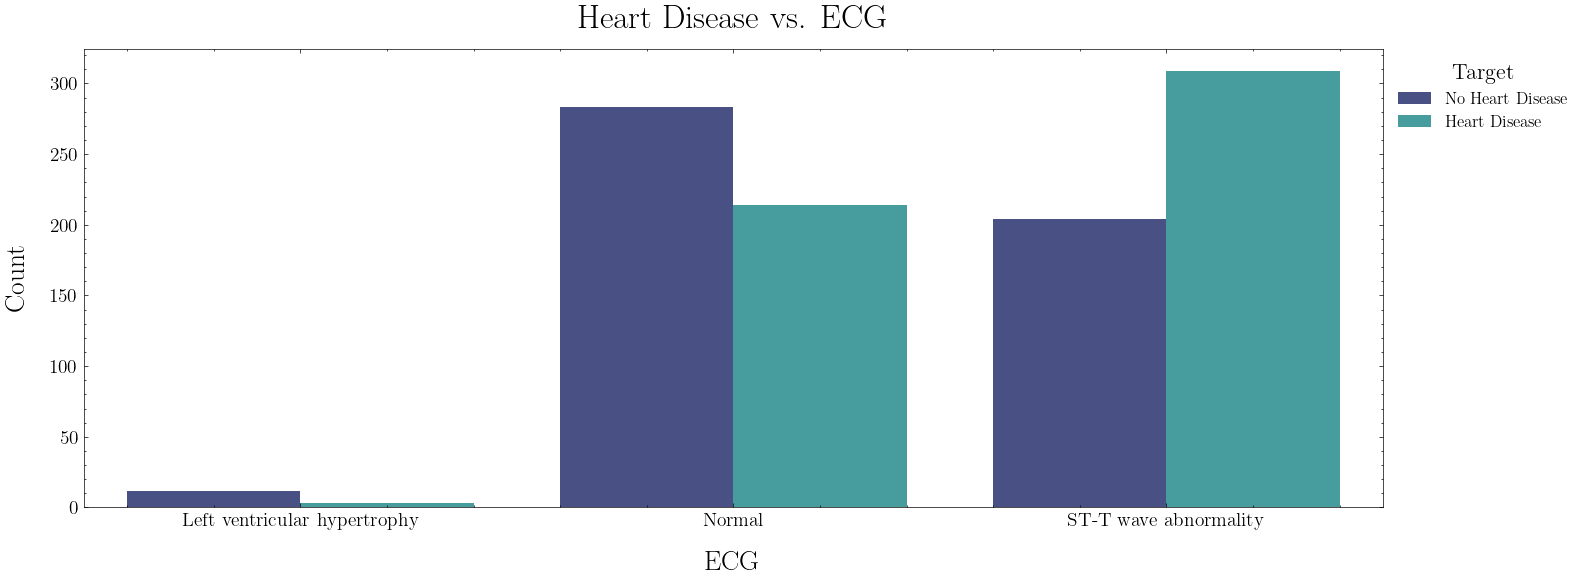

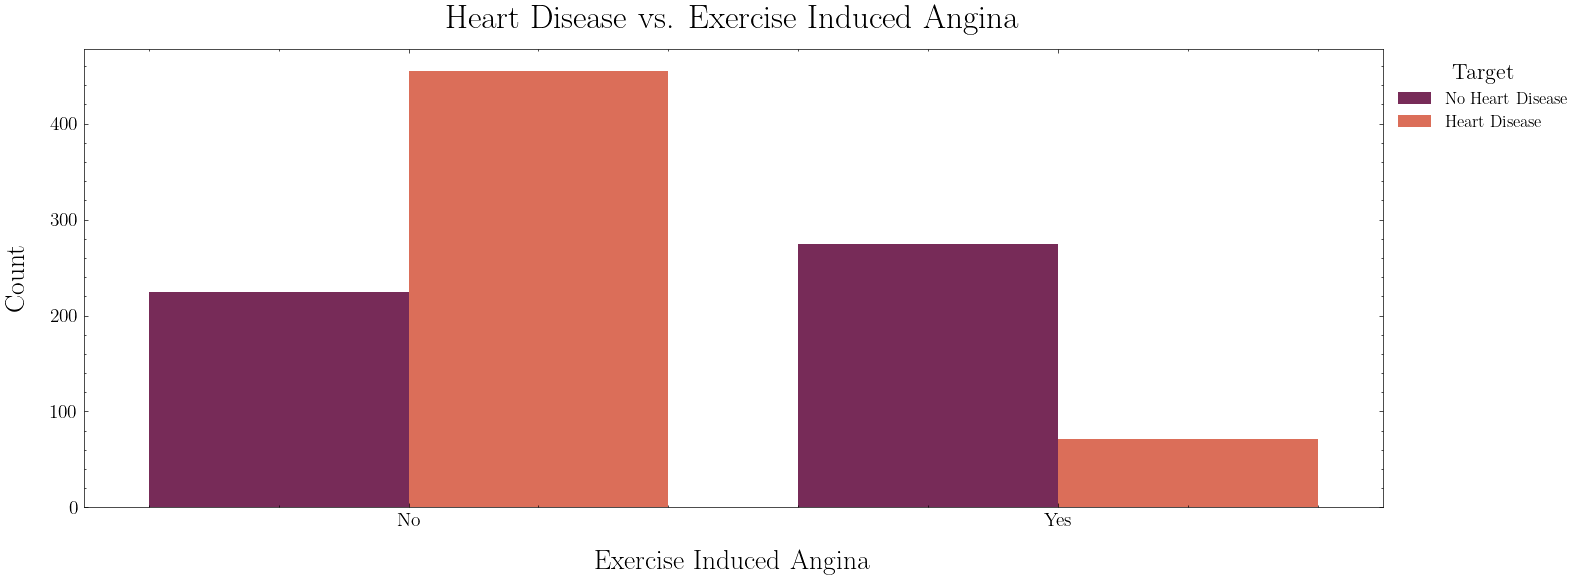

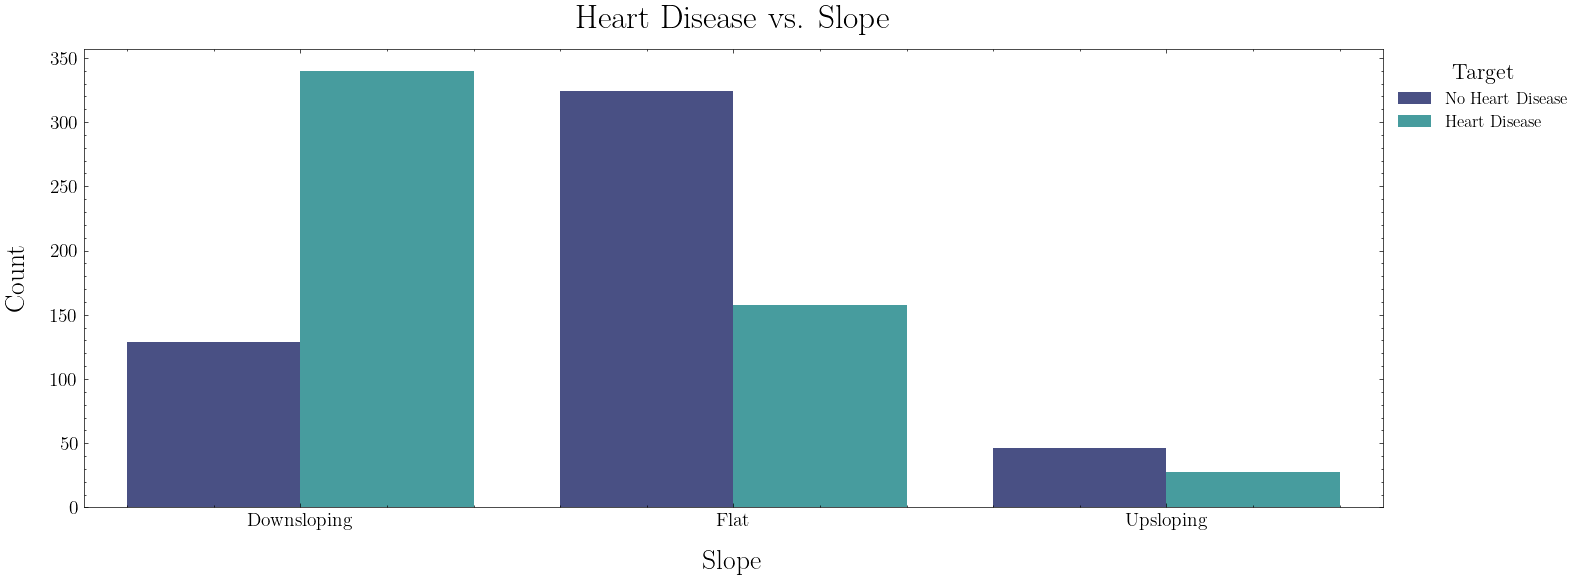

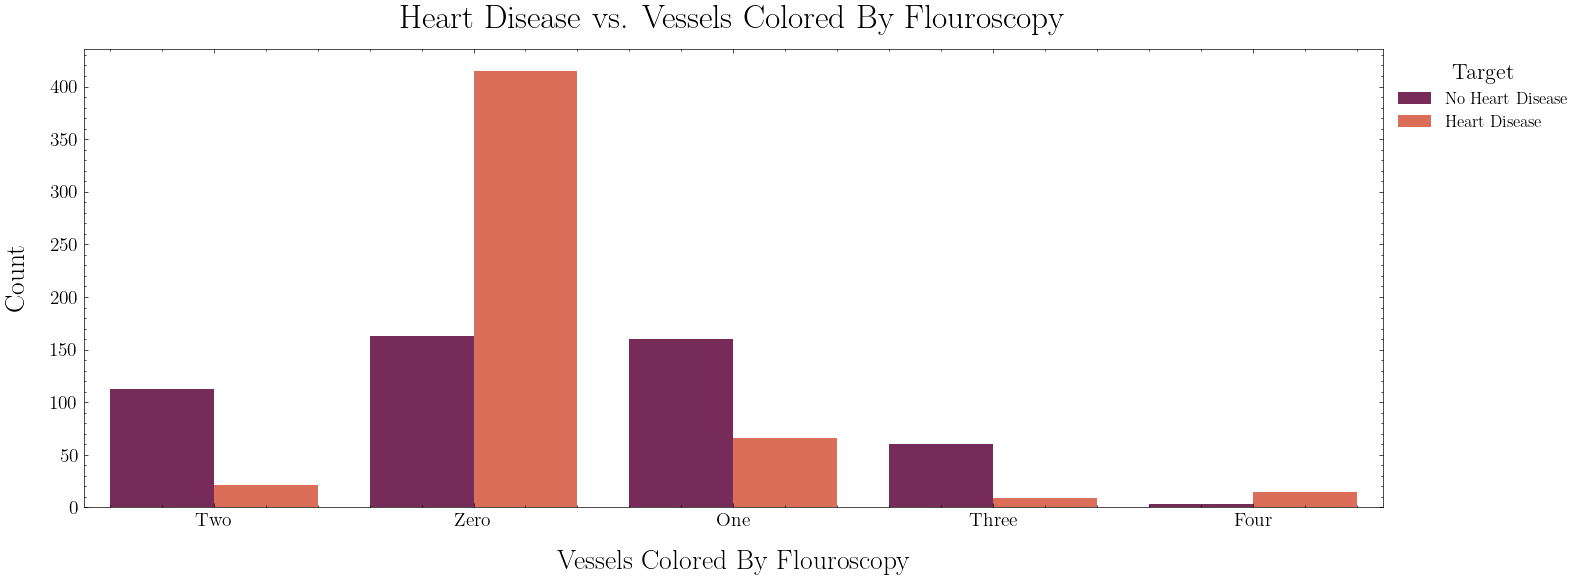

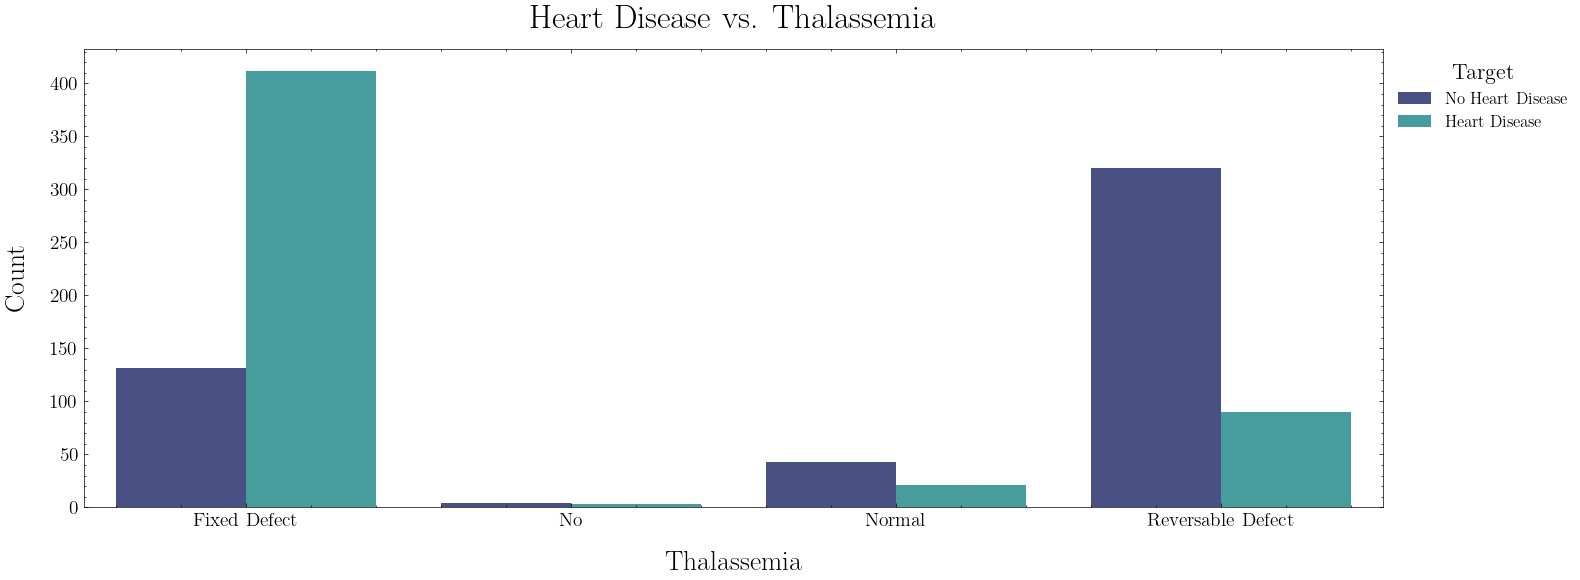

In [19]:
plot_categorical(df_heart, categorical)

As described above, I was shocked at the low correlation between heart disease and the numeric variables. I assumed:
* Age would be a determing factor
* Cholesterol would be more prominent
* A male would be more susceptible

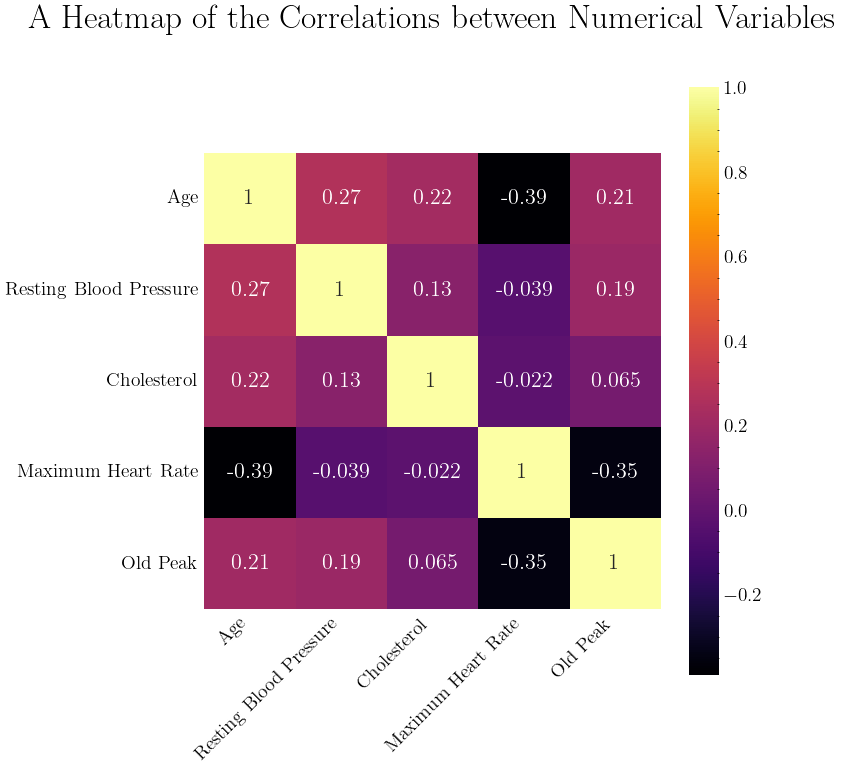

In [20]:
figsize = (8, 8)
fig, ax = plt.subplots(figsize=figsize)

correlation = df_heart.drop('target', axis=1).select_dtypes('number').corr()

heatmap = sns.heatmap(
    correlation,
    annot=True,
    annot_kws={'size': 16},
    cmap='inferno',
    square=True
)

x_labels = [column_to_title(col) for col in correlation.columns]
y_labels = [column_to_title(col) for col in correlation.index]

ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.tick_params(axis='both', which='both', length=0)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(length=0)  

ax.set_title('A Heatmap of the Correlations between Numerical Variables', pad=90)

plt.tight_layout()
plt.show()
plt.close()

$$\text{\Huge{Logistic Regression (statsmodels)}}$$

$$\text{\Large{Data preprocessing}}$$

The dataset consisted of a combination of categorical and numerical data, as such, I had to scale numeric variables using Standard Scaler, convert categorical variables using One Hot Encoding and encode a categorical target variable using an Ordinal Encoder in a decision tree.

*   One Hot Encoding is useful to transform a categorical variable into a binary representation, depending on the number of values in each column. It is most common to use One Hot Encoding on non-ordinal data, where ranking does not matter. It is important to improve predictability and scalability in machine learning algorithms.

*   A Standard Scaler is important to use so our features are compared on the same scale. It rescales each column to have a mean of 0 and standard deviation of 1.

*   An Ordinal Encoder is used when categorical features are converted to integers. This will transform a column into integers that range from 0 to n - 1 where n is the number of categories present. It is typically used when there is a ranking, but I use it because my target variable in my decision tree is categorical.

In [21]:
df_heart['vessels_colored_by_flouroscopy'] = df_heart['vessels_colored_by_flouroscopy'].map(
    {
        'Zero': 0,
        'One': 1,
        'Two': 2,
        'Three': 3,
        'Four': 4,
    }
)

pd.to_numeric(
    df_heart['vessels_colored_by_flouroscopy'],
    downcast='integer'
)

0       2
1       0
2       0
3       1
4       3
       ..
1020    0
1021    1
1022    1
1023    0
1024    1
Name: vessels_colored_by_flouroscopy, Length: 1025, dtype: int8

In [22]:
df_heart_regression = df_heart.copy()

# Create dummy variables
df_categorical = pd.get_dummies(df_heart_regression[categorical])

# Transform the column names to snakecase
df_categorical.columns = df_categorical.columns.str.lower()
df_categorical.columns = df_categorical.columns.str.replace(' ', '_')
df_categorical.columns = df_categorical.columns.str.replace('-', '_')
df_categorical.columns = df_categorical.columns.str.replace('/', '_')

# Add them back to the original dataframe
df_heart_regression = pd.concat(
    [df_heart_regression, df_categorical],
    axis=1
)

# Drop the old columns
df_heart_regression = df_heart_regression.drop(categorical, axis=1)

# Take a look
df_heart_regression

age  resting_blood_pressure  cholesterol  max_heart_rate  old_peak  \
0      52                     125          212             168       1.0   
1      53                     140          203             155       3.1   
2      70                     145          174             125       2.6   
3      61                     148          203             161       0.0   
4      62                     138          294             106       1.9   
...   ...                     ...          ...             ...       ...   
1020   59                     140          221             164       0.0   
1021   60                     125          258             141       2.8   
1022   47                     110          275             118       1.0   
1023   50                     110          254             159       0.0   
1024   54                     120          188             113       1.4   

      target  sex_female  sex_male  chest_pain_type_asymptomatic  \
0          0       False      True                         False   
1          0       False      True                         False   
2          0       False      True                         False   
3          0       False      True                         False   
4          0        True     False                         False   
...      ...         ...       ...                           ...   
1020       1       False      True                         False   
1021       0       False      True                         False   
1022       0       False      True                         False   
1023       1        True     False                         False   
1024       0       False      True                         False   

      chest_pain_type_atypical_angina  ...  rest_ecg_st_t_wave_abnormality  \
0                               False  ...                            True   
1                               False  ...                           False   
2                               False  ...                            True   
3                               False  ...                            True   
4                               False  ...                            True   
...                               ...  ...                             ...   
1020                             True  ...                            True   
1021                            False  ...                           False   
1022                            False  ...                           False   
1023                            False  ...                           False   
1024                            False  ...                            True   

      exercise_induced_angina_no  exercise_induced_angina_yes  \
0                           True                        False   
1                          False                         True   
2                          False                         True   
3                           True                        False   
4                           True                        False   
...                          ...                          ...   
1020                       False                         True   
1021                       False                         True   
1022                       False                         True   
1023                        True                        False   
1024                        True                        False   

      slope_downsloping  slope_flat  slope_upsloping  \
0                  True       False            False   
1                 False       False             True   
2                 False       False             True   
3                  True       False            False   
4                 False        True            False   
...                 ...         ...              ...   
1020               True       False            False   
1021              False        True            False   
1022              False        True            False  

In [23]:
df_train_lr_sm, df_test_lr_sm = train_test_split(df_heart_regression, test_size=0.20)

In [24]:
df_train_lr_sm.shape

(820, 26)

In [25]:
df_test_lr_sm.shape

(205, 26)

In [26]:
# Create the standard scaler object
scaler = StandardScaler()

# Use this object to fit (i.e., to calculate the mean and std of each variable in the training data) and then to transform the training data
df_train_lr_sm[numerical] = scaler.fit_transform(df_train_lr_sm[numerical])

# Use the fit from the training data to transform the test data
df_test_lr_sm[numerical] = scaler.transform(df_test_lr_sm[numerical])

$$\text{\Large{Build a model}}$$

In [27]:
column = df_heart_regression.columns.tolist()
column.remove('target')

formula = 'target ~ ' + ' + '.join(column)

# Define model parameters
model = smf.logit(formula, data=df_train_lr_sm)

# Fit the model to the training data
results = model.fit()

# Get a summary of the model parameters
results.summary()

Optimization terminated successfully.
         Current function value: 0.378403
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  820
Model:                          Logit   Df Residuals:                      801
Method:                           MLE   Df Model:                           18
Date:                Fri, 03 May 2024   Pseudo R-squ.:                  0.4533
Time:                        17:39:09   Log-Likelihood:                -310.29
converged:                       True   LL-Null:                       -567.59
Covariance Type:            nonrobust   LLR p-value:                 8.865e-98
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              0.1260        nan        nan        nan         nan         nan
sex_female[T.True]                                     0.8855    6.2e+06   1.43e-07      1.000   -1.22e+07    1.22e+07
sex_male[T.True]                                      -0.7595   6.46e+06  -1.18e-07      1.000   -1.27e+07    1.27e+07
chest_pain_type_asymptomatic[T.True]                   0.8717        nan        nan        nan         nan         nan
chest_pain_type_atypical_angina[T.True]               -0.1548        nan        nan        nan         nan         nan
chest_pain_type_non_anginal_pain[T.True]               0.7043        nan        nan        nan         nan         nan
chest_pain_type_typical_angina[T.True]                -1.2951        nan        nan        nan         nan         nan
fasting_blood_sugar_greater_than_120_mg_ml[T.True]    -0.0219    4.5e+06  -4.87e-09      1.000   -8.82e+06    8.82e+06
fasting_blood_sugar_lower_than_120_mg_ml[T.True]       0.1480   5.52e+06   2.68e-08      1.000   -1.08e+07    1.08e+07
rest_ecg_left_ventricular_hypertrophy[T.True]         -0.4031        nan        nan        nan         nan         nan
rest_ecg_normal[T.True]                                0.0283        nan        nan        nan         nan         nan
rest_ecg_st_t_wave_abnormality[T.True]                 0.5009        nan        nan        nan         nan         nan
exercise_induced_angina_no[T.True]                     0.3528   3.12e+06   1.13e-07      1.000   -6.12e+06    6.12e+06
exercise_induced_angina_yes[T.True]                   -0.2267   2.21e+06  -1.03e-07      1.000   -4.33e+06    4.33e+06
slope_downsloping[T.True]                              0.1909        nan        nan        nan         nan         nan
slope_flat[T.True]                                    -0.4018        nan        nan        nan         nan         nan
slope_upsloping[T.True]                                0.3370        nan        nan        nan         nan         nan
thalassemia_fixed_defect[T.True]                       0.5696        nan        nan        nan         nan         nan
thalassemia_no[T.True]                                -0.5825        nan        nan        nan         nan         nan
thalassemia_normal[T.True]                             0.7384        nan        nan        nan         nan         nan
thalassemia_reversable_defect[T.True]                 -0.5996        nan        nan        nan         nan         nan
age                                                   -0.2089      0.123     -1.698      0.090      -0.450       0.032
resting_blood_pressure                                -0.1893      0.106     -1.783      0.075      -0.397       0.019
cholesterol                                           -0.2810      0.111     -2.526      0.012      -0.499      -0.063
max_heart_rate              

In [28]:
df_importance = pd.DataFrame(
    {
        'variable': results.params.index,
        'importance': results.params.values,
    }
)

df_importance['variable'] = (
    df_importance['variable']
    .str.replace('[T.True]', '', regex=False)
)

positive_importance = df_importance[df_importance.importance > 0]
negative_importance = df_importance[df_importance.importance < 0]

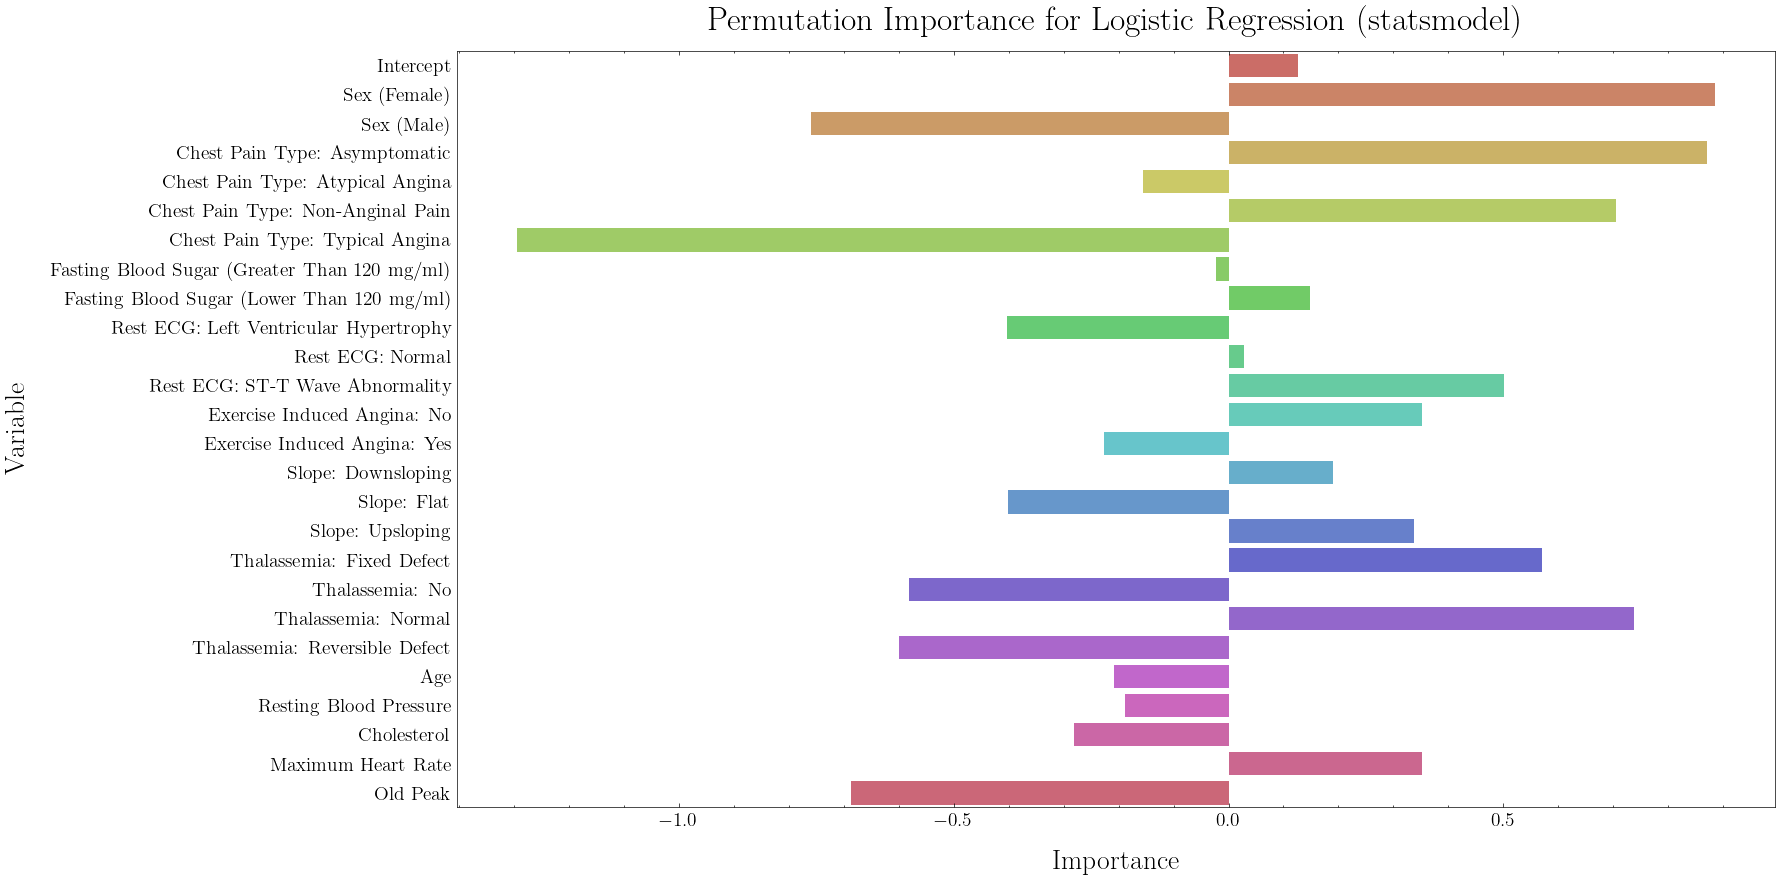

In [29]:
display_permutation_importance(df_importance, name='Logistic Regression (statsmodel)')

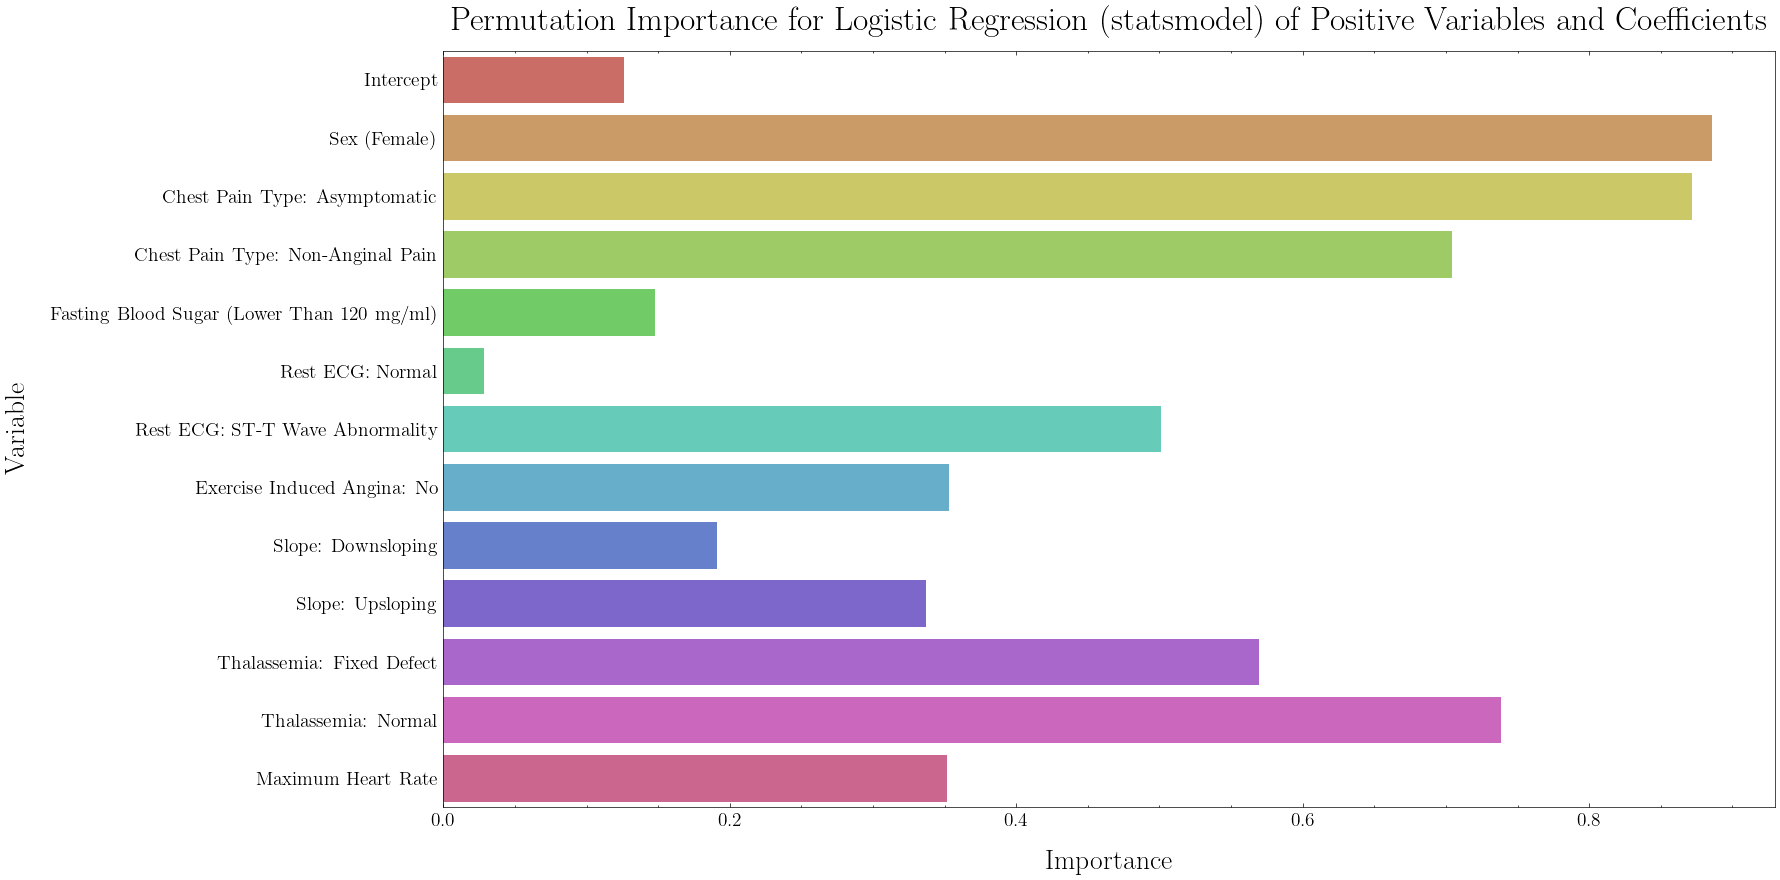

In [30]:
if not positive_importance.empty:
    display_permutation_importance(positive_importance, name='Logistic Regression (statsmodel) of Positive Variables and Coefficients')

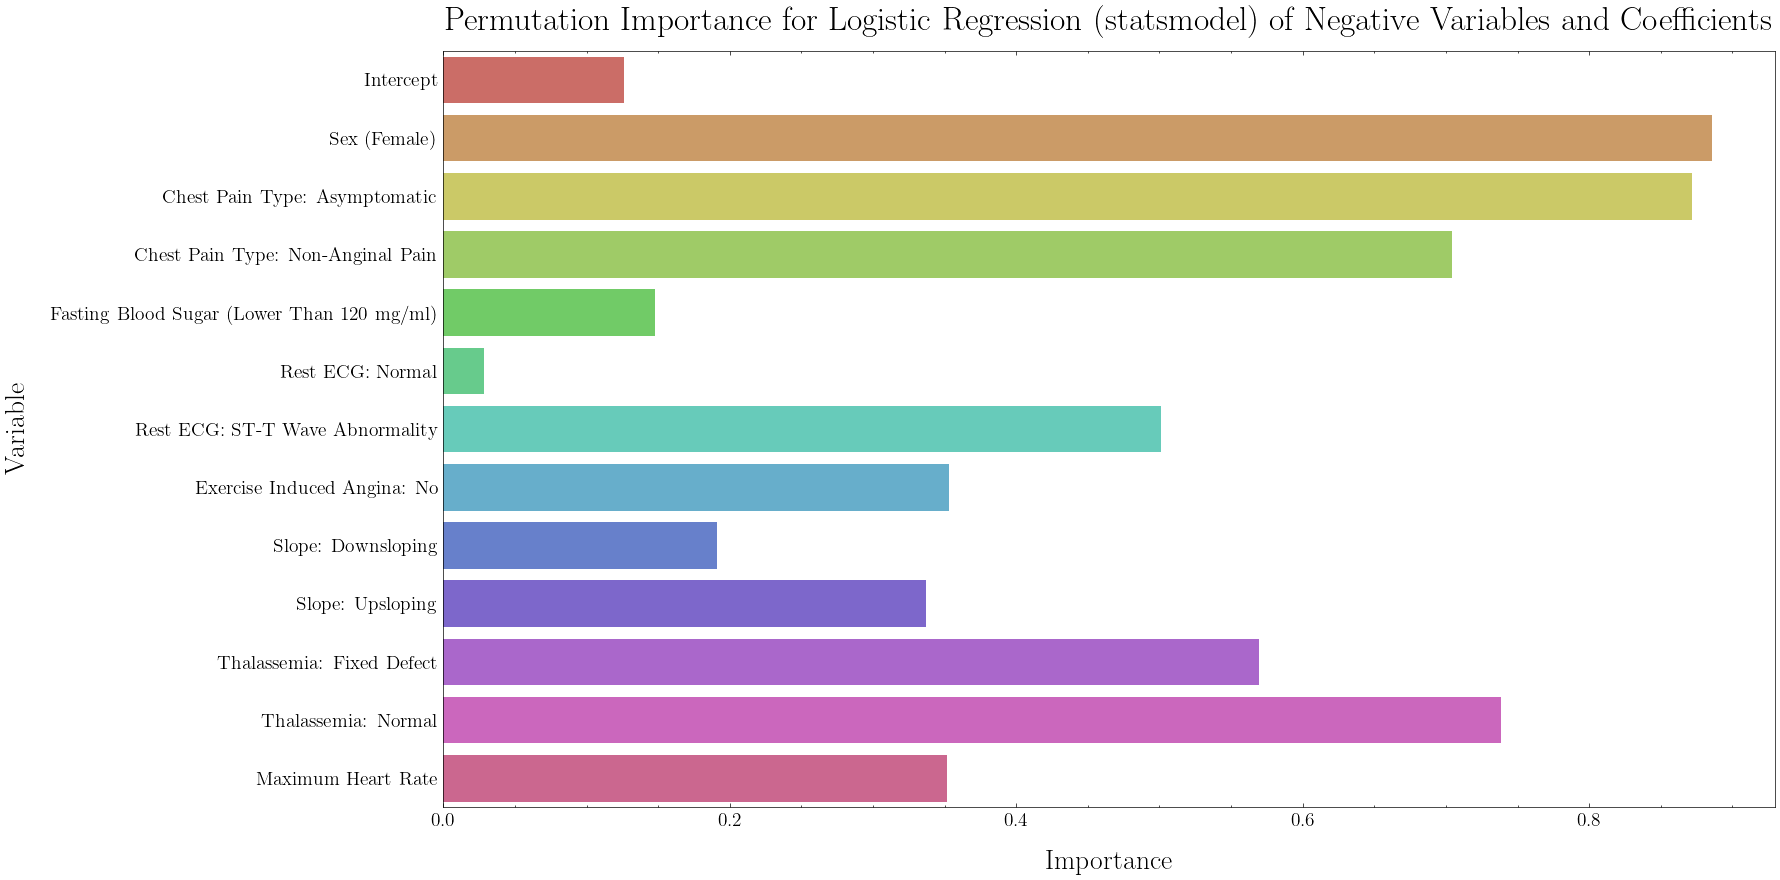

In [31]:
if not negative_importance.empty:
    display_permutation_importance(positive_importance, name='Logistic Regression (statsmodel) of Negative Variables and Coefficients')

In [32]:
# Let's first predict values in the testing dataset
df_test_lr_sm['target_probability'] = results.predict(df_test_lr_sm).round(2)

# Here we've used 0.5 as the threshold of heart disease or not
df_test_lr_sm['target_prediction'] = (df_test_lr_sm['target_probability'] > 0.5).astype(int)

df_test_lr_sm

age  resting_blood_pressure  cholesterol  max_heart_rate  old_peak  \
991  0.597127               -0.843598    -0.318976        0.478001  0.290626   
621 -0.735842               -0.090562     0.185630        0.039173 -0.900516   
3    0.708208                0.952104    -0.842990        0.521883 -0.900516   
491  0.263885                1.067955    -1.522267        1.092359  0.460790   
85  -1.180165               -0.669821    -0.513055        0.916828 -0.900516   
..        ...                     ...          ...             ...       ...   
508  0.152804                3.964249     0.806683       -0.706833  2.502748   
810 -1.624488               -1.249080    -1.541675       -1.540605  0.801116   
67  -1.402327                0.256993     1.330697       -1.057895  0.630953   
935  0.152804               -0.669821    -0.124897        0.872945 -0.900516   
767  1.485773                0.720400    -1.037069       -0.355771  1.992258   

     target  sex_female  sex_male  chest_pain_type_asymptomatic  \
991       0       False      True                         False   
621       0       False      True                         False   
3         0       False      True                         False   
491       1       False      True                         False   
85        1       False      True                         False   
..      ...         ...       ...                           ...   
508       0        True     False                         False   
810       0       False      True                         False   
67        0       False      True                         False   
935       1       False      True                         False   
767       0       False      True                         False   

     chest_pain_type_atypical_angina  ...  exercise_induced_angina_yes  \
991                            False  ...                         True   
621                            False  ...                         True   
3                              False  ...                        False   
491                            False  ...                        False   
85                              True  ...                        False   
..                               ...  ...                          ...   
508                            False  ...                         True   
810                            False  ...                         True   
67                             False  ...                         True   
935                             True  ...                        False   
767                            False  ...                        False   

     slope_downsloping  slope_flat  slope_upsloping  thalassemia_fixed_defect  \
991               True       False            False                     False   
621               True       False            False                     False   
3                 True       False            False                     False   
491               True       False            False                      True   
85                True       False            False                      True   
..                 ...         ...              ...                       ...   
508              False       False             True                     False   
810              False        True            False                     False   
67               False        True            False                     False   
935              False       False             True                      True   
767              False        True            False                     False   

     thalassemia_no  thalassemia_normal  thalassemia_reversable_defect  \
991           False               False                           True   
621           False               False                           True   
3             False               False                           True   
491           False               False                          False   
85          

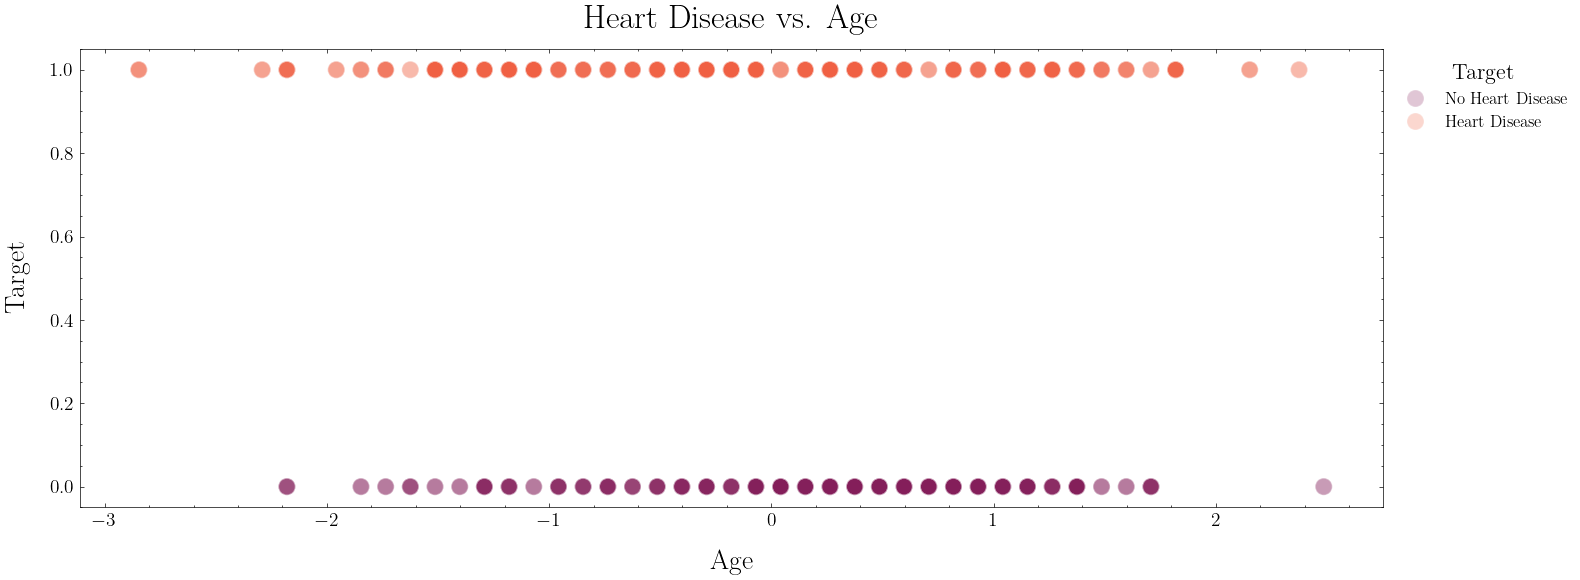

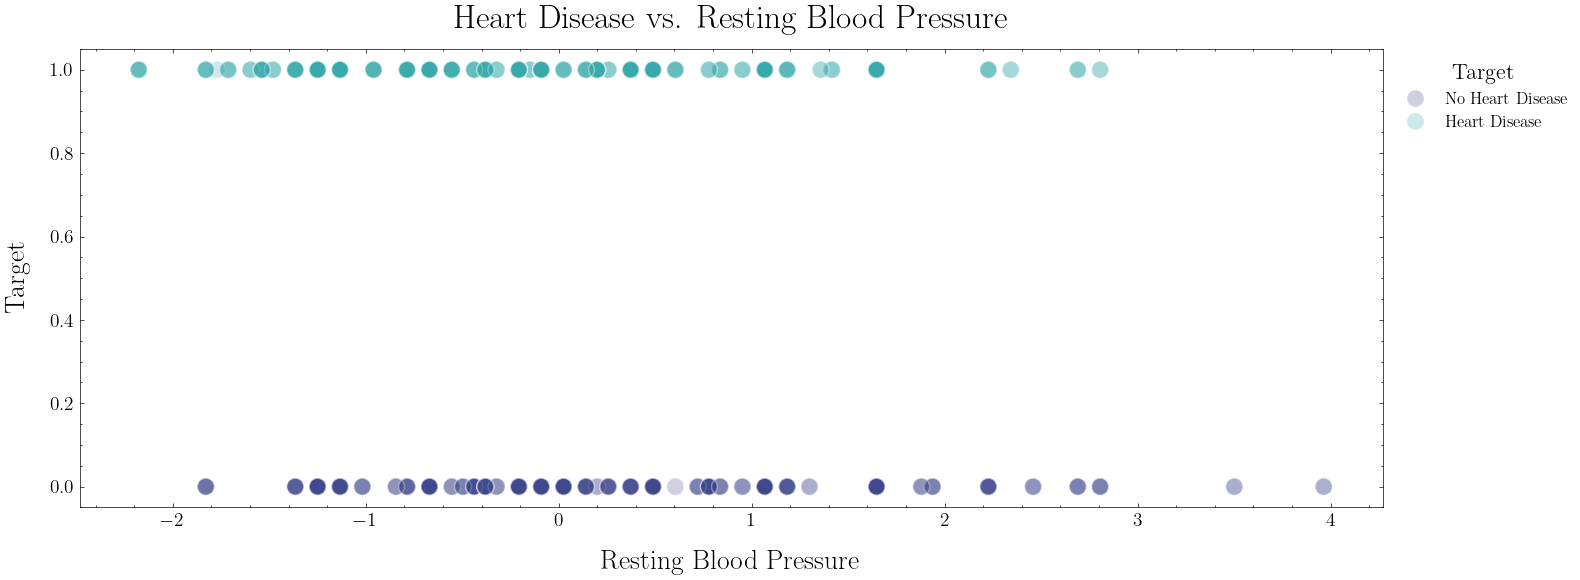

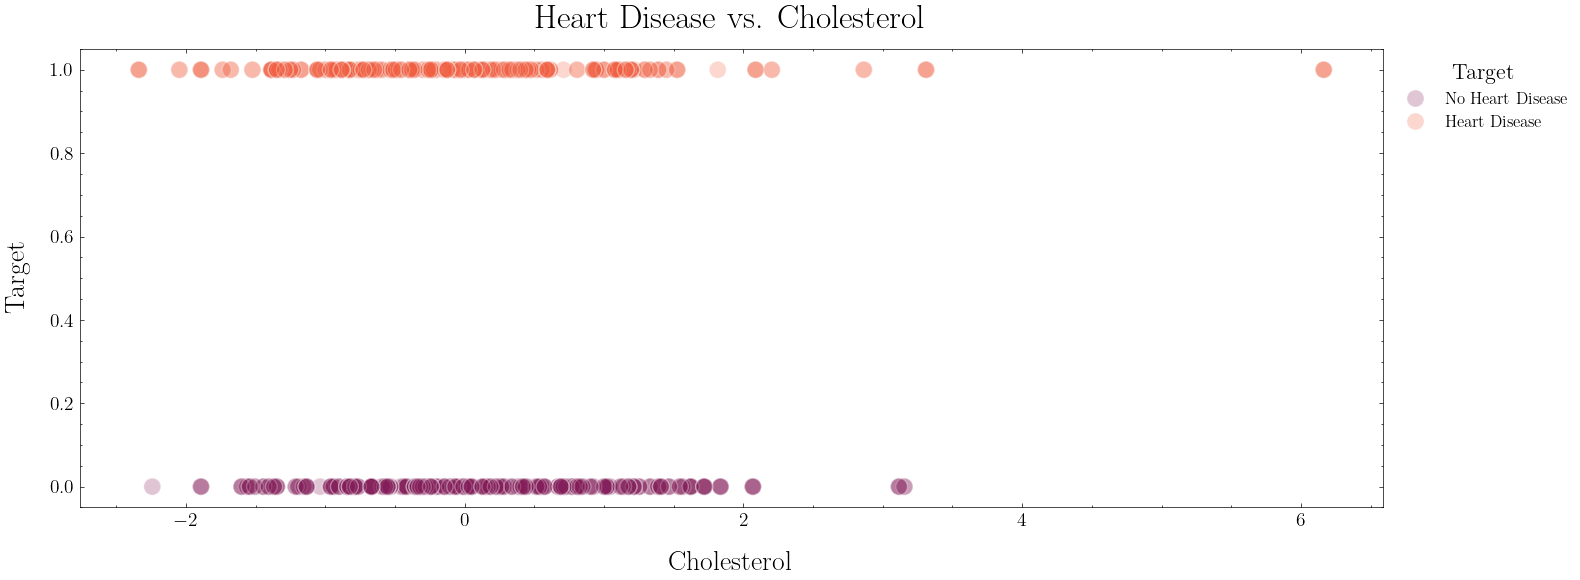

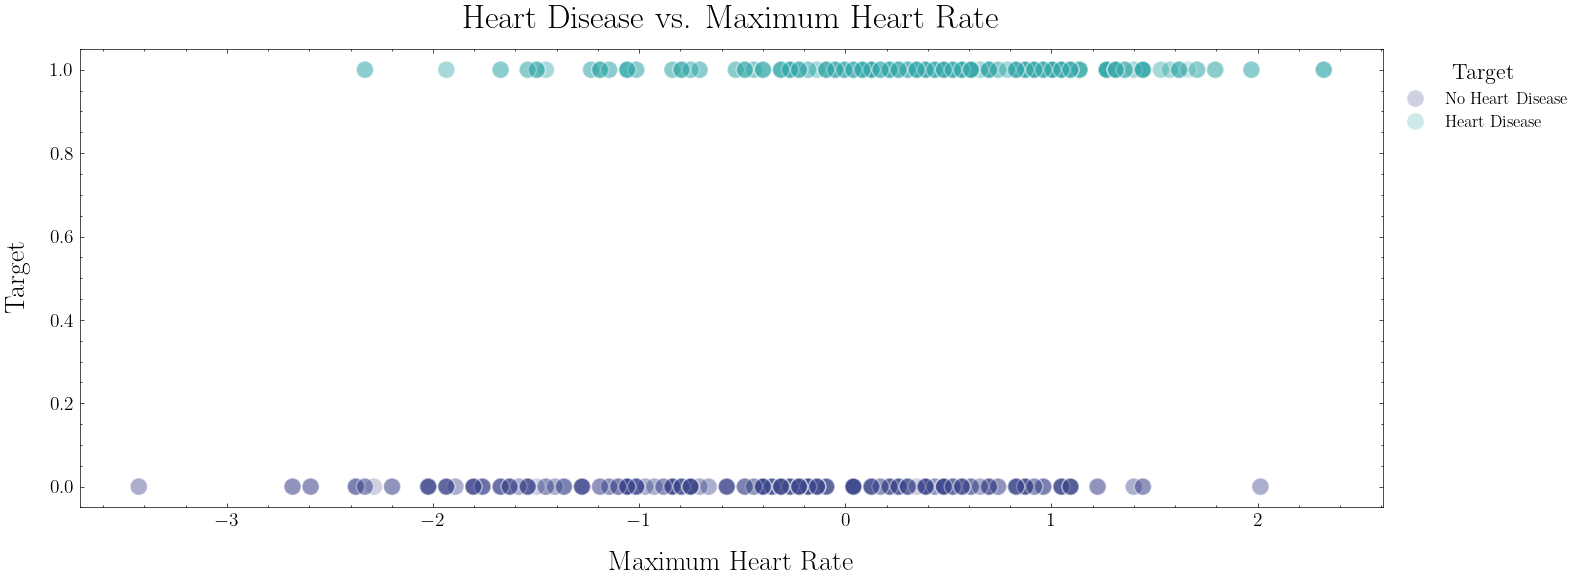

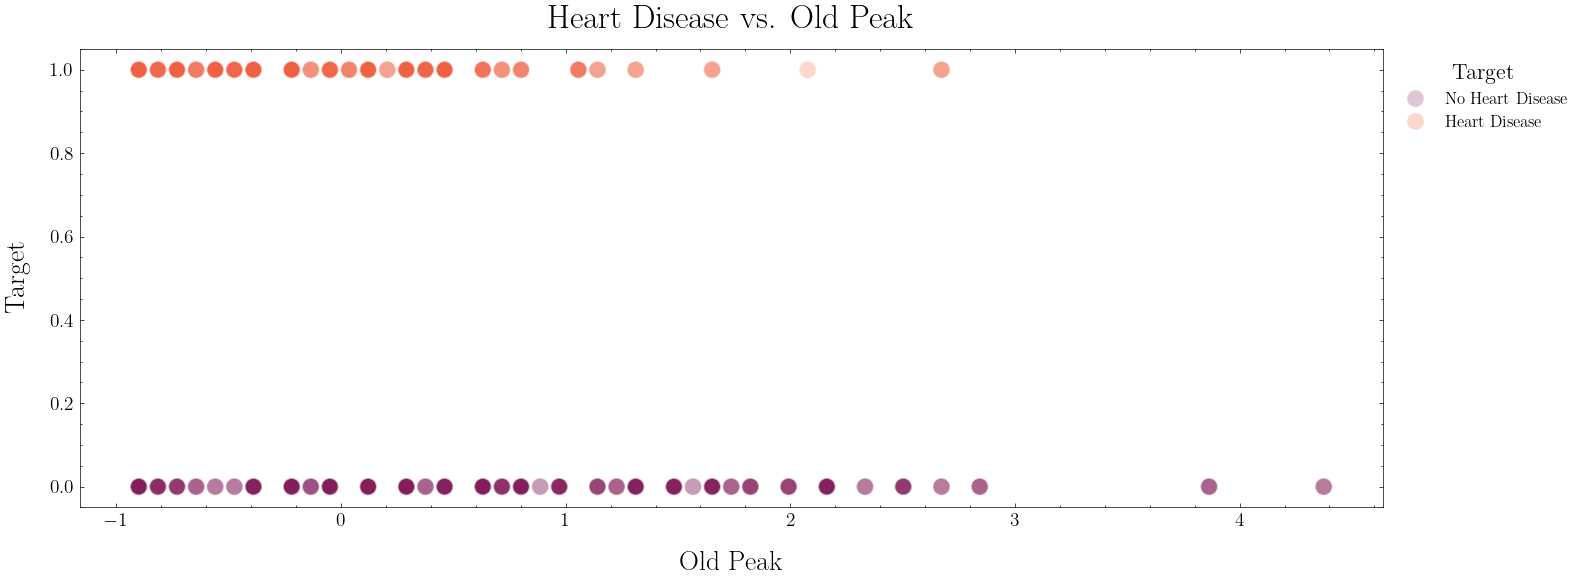

In [33]:
plot_numerical(df_train_lr_sm, numerical)

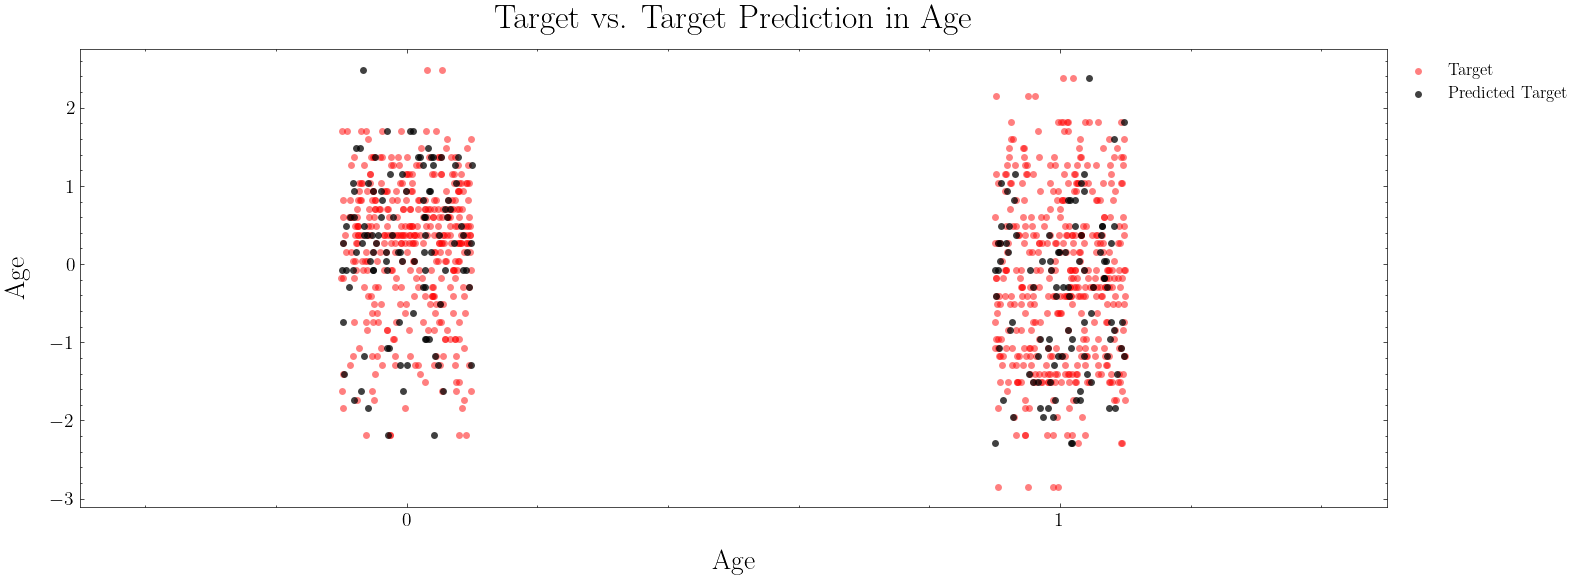

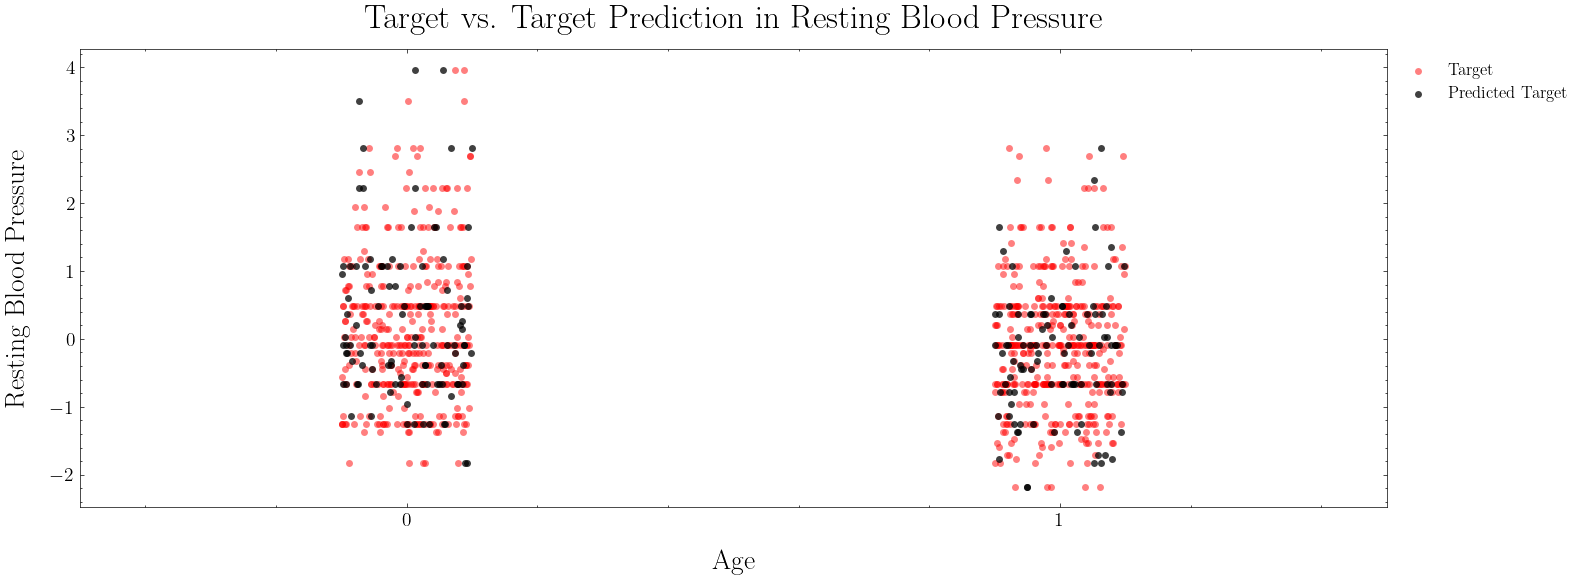

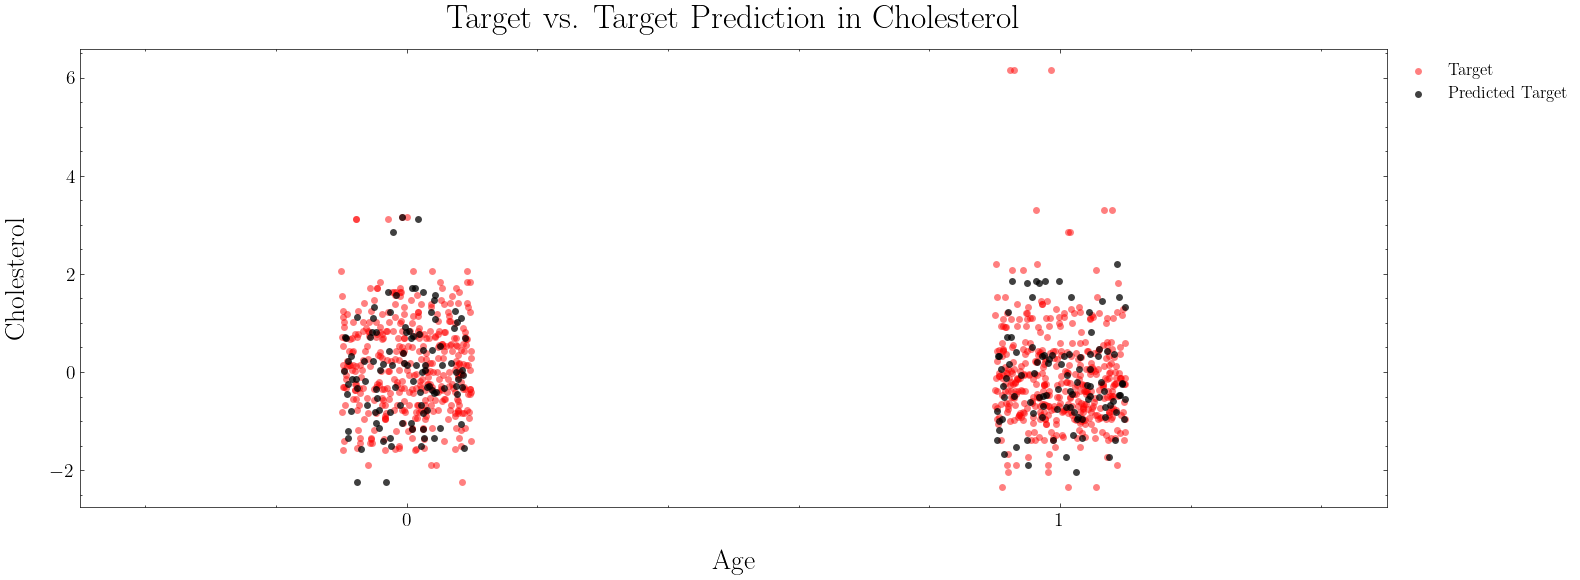

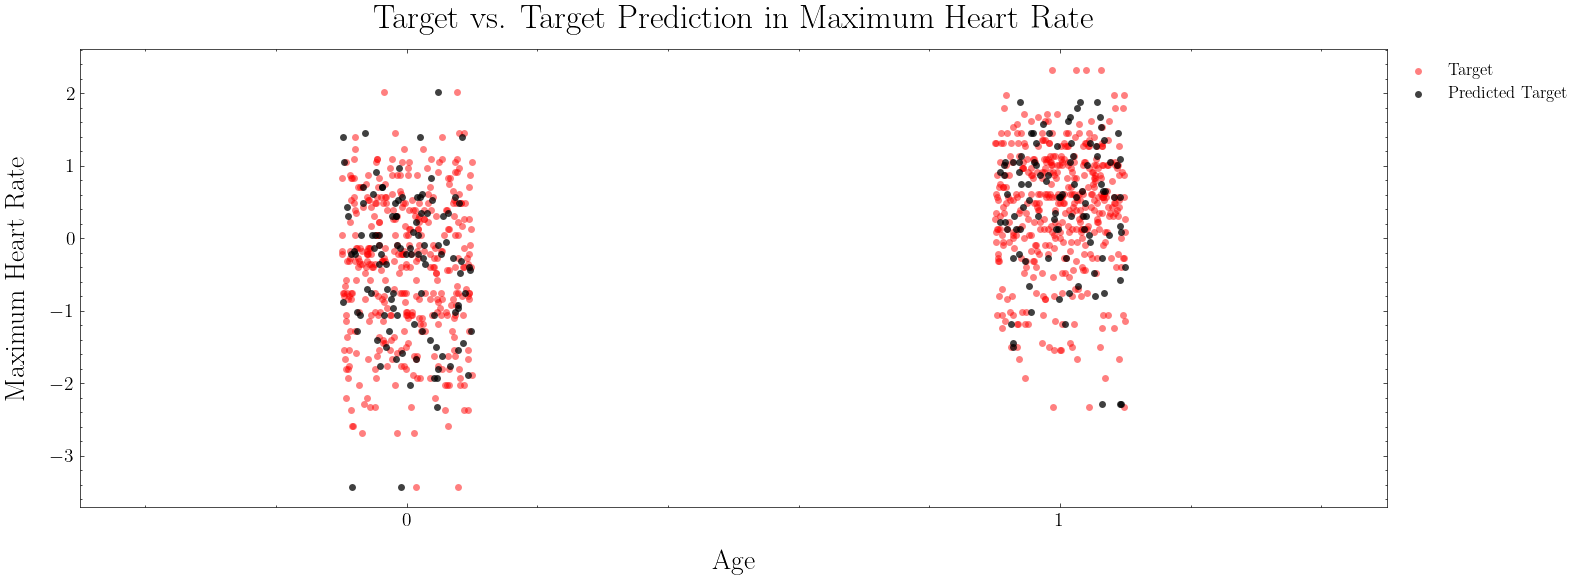

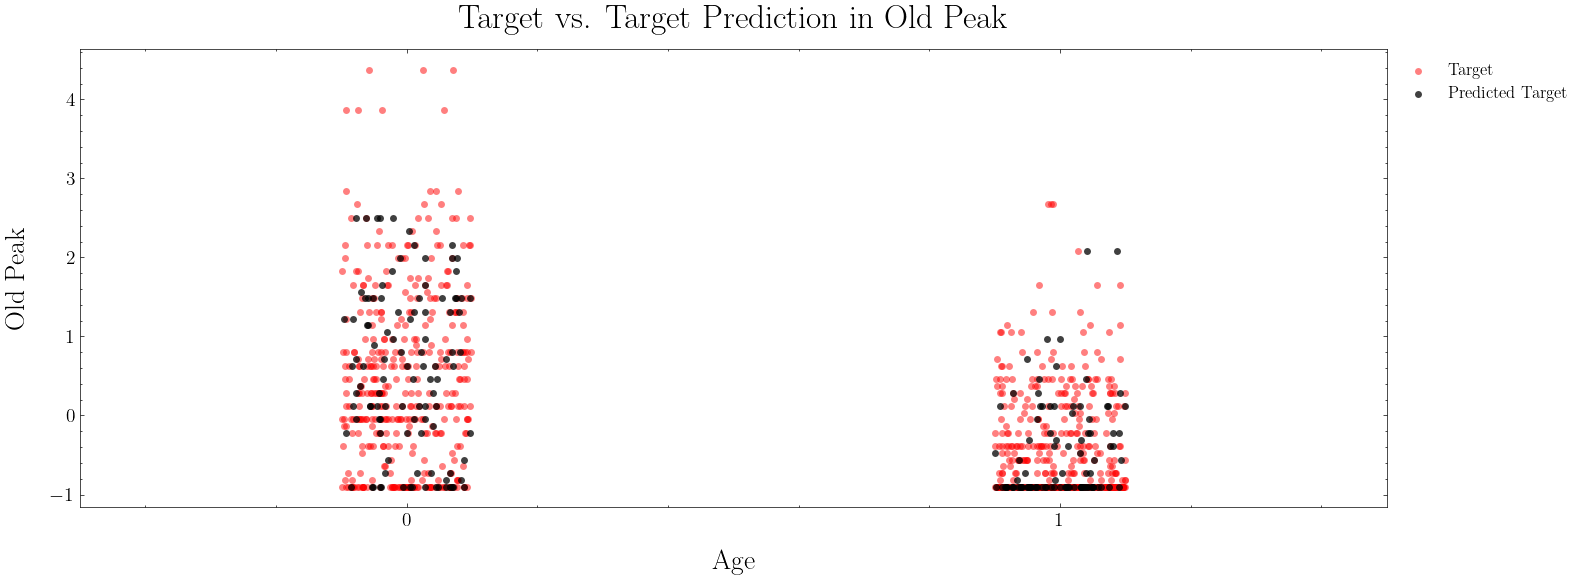

In [34]:
for y in numerical:
    figsize = (16, 6)
    fig, ax = plt.subplots(figsize=figsize)

    sns.stripplot(
        data=df_train_lr_sm,
        x='target',
        y=y,
        color='red',
        label='Target',
        alpha=0.50,
        ax=ax
    )

    sns.stripplot(
        data=df_test_lr_sm,
        x='target_prediction',
        y=y,
        color='black',
        label='Predicted Target',
        alpha=0.75,
        ax=ax
    )

    y = ax.yaxis.get_label().get_text()
    x = column_to_title(x)
    y = column_to_title(y)

    ax.set_xlabel(x)
    ax.set_ylabel(y)

    handle, label = ax.get_legend_handles_labels()
    th, _, pth, _ = handle
    tl, _, ptl, _ = label

    plt.legend(
        [th, pth],
        [tl, ptl],
        loc='upper left', 
        bbox_to_anchor=(1, 1)
    )
    
    ax.set_title('Target vs. Target Prediction in ' + y)

    plt.tight_layout()
    plt.show()
    plt.close()
    
    print('\n')

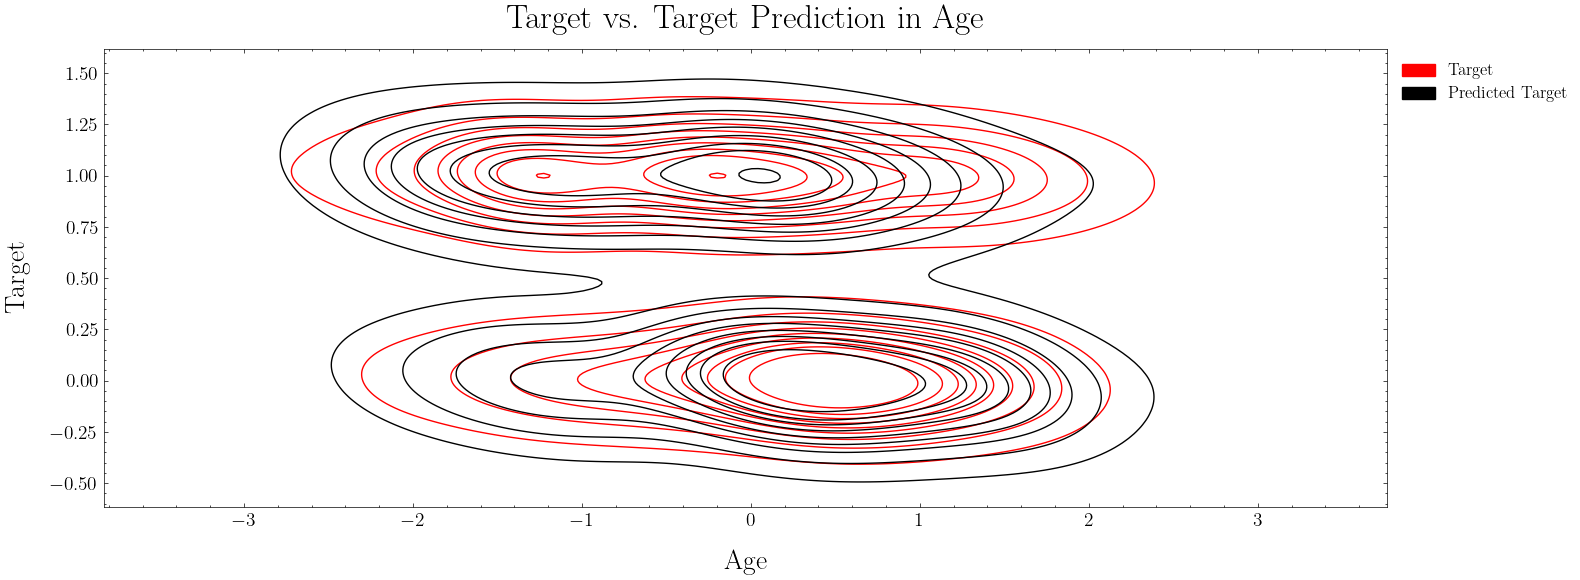

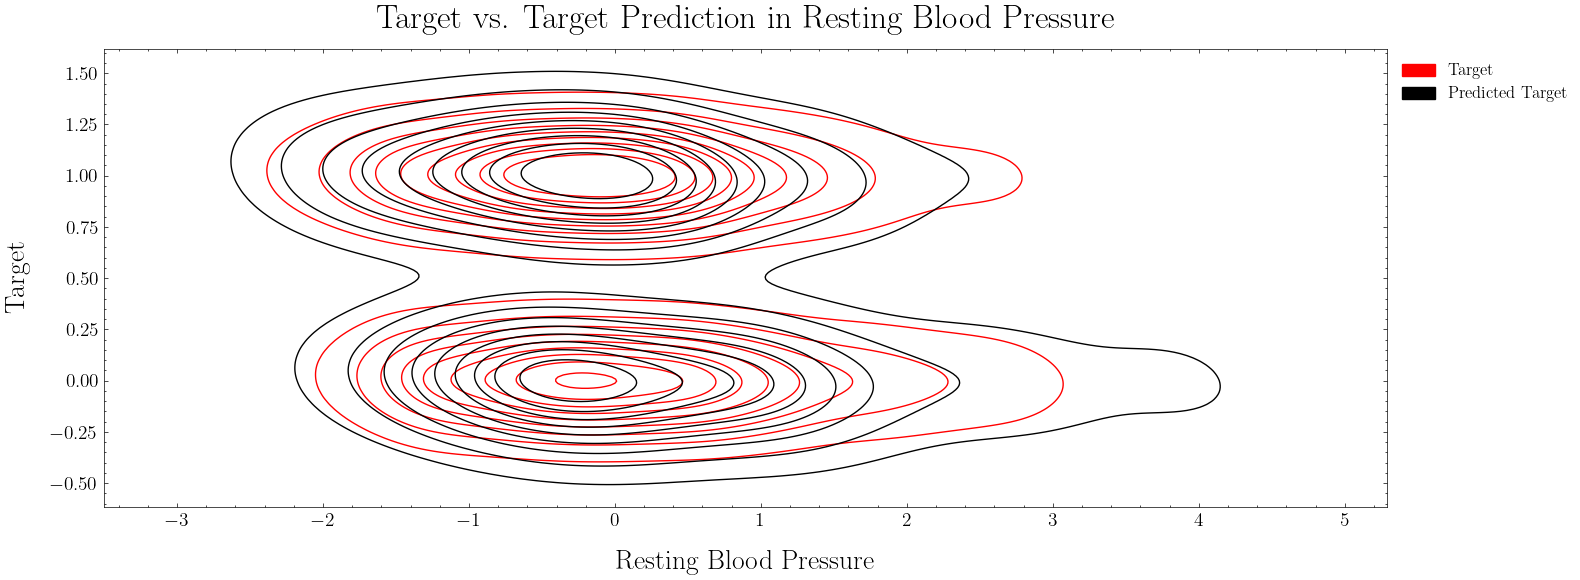

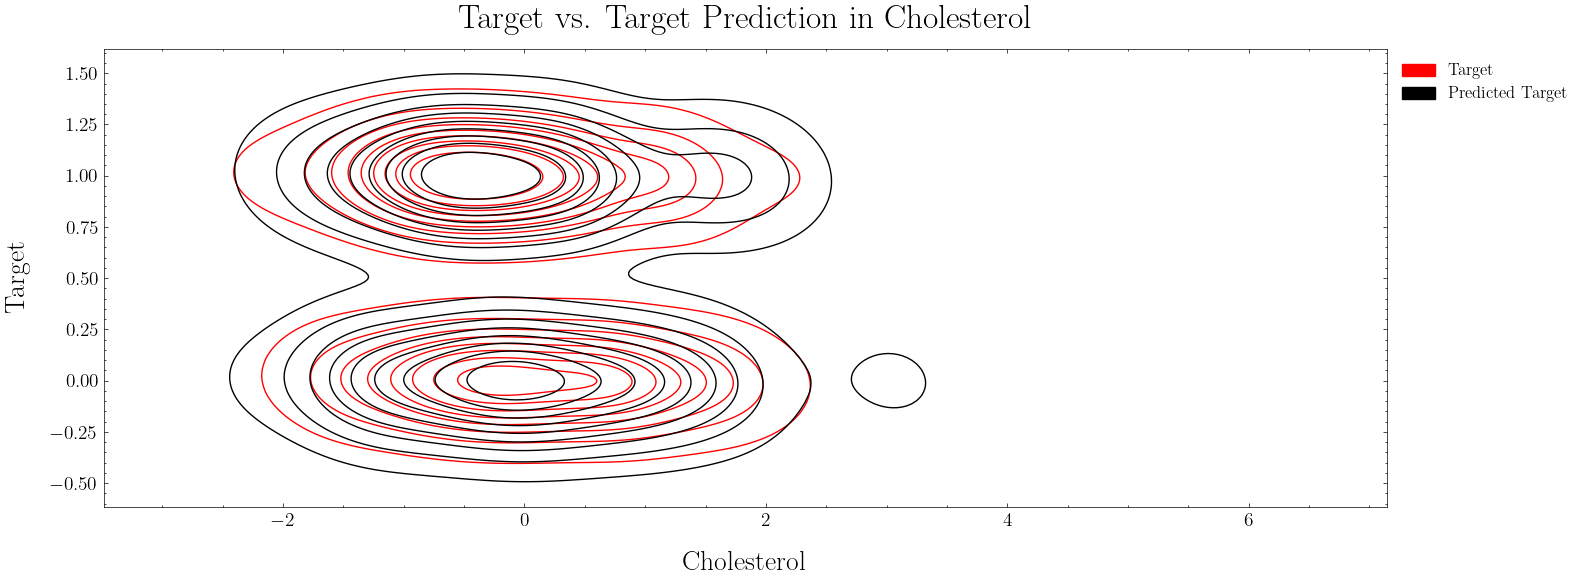

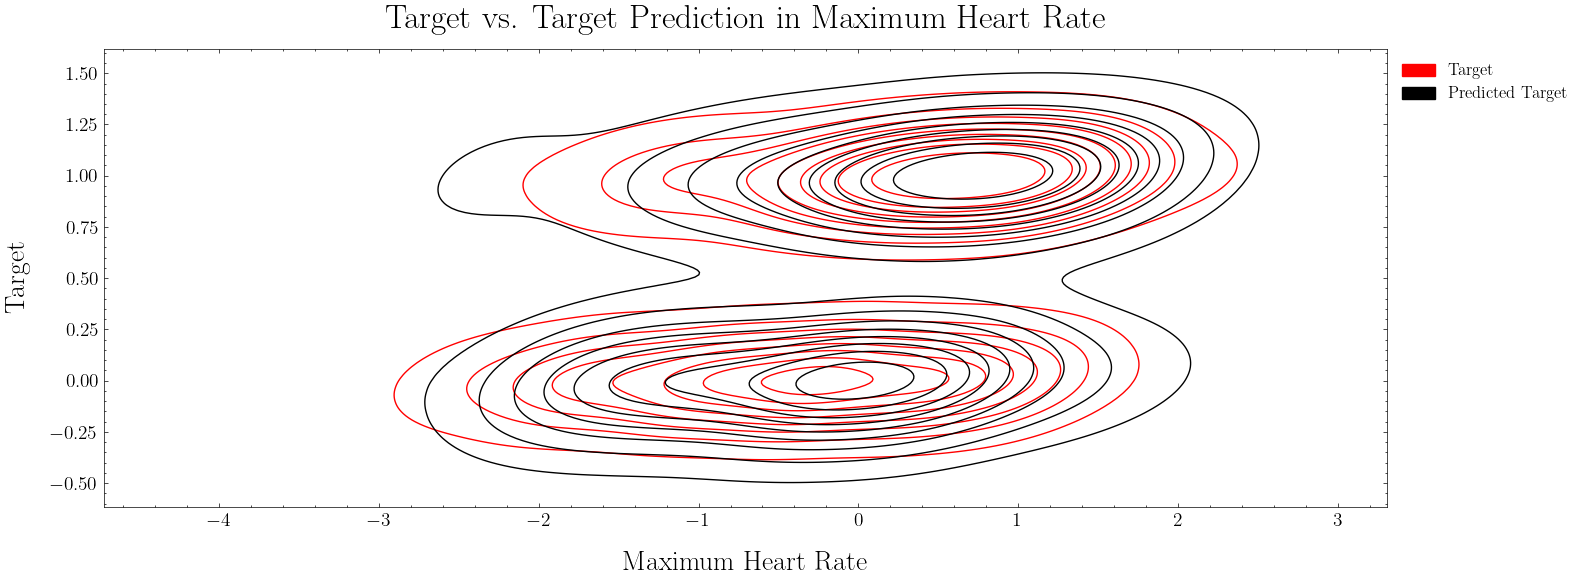

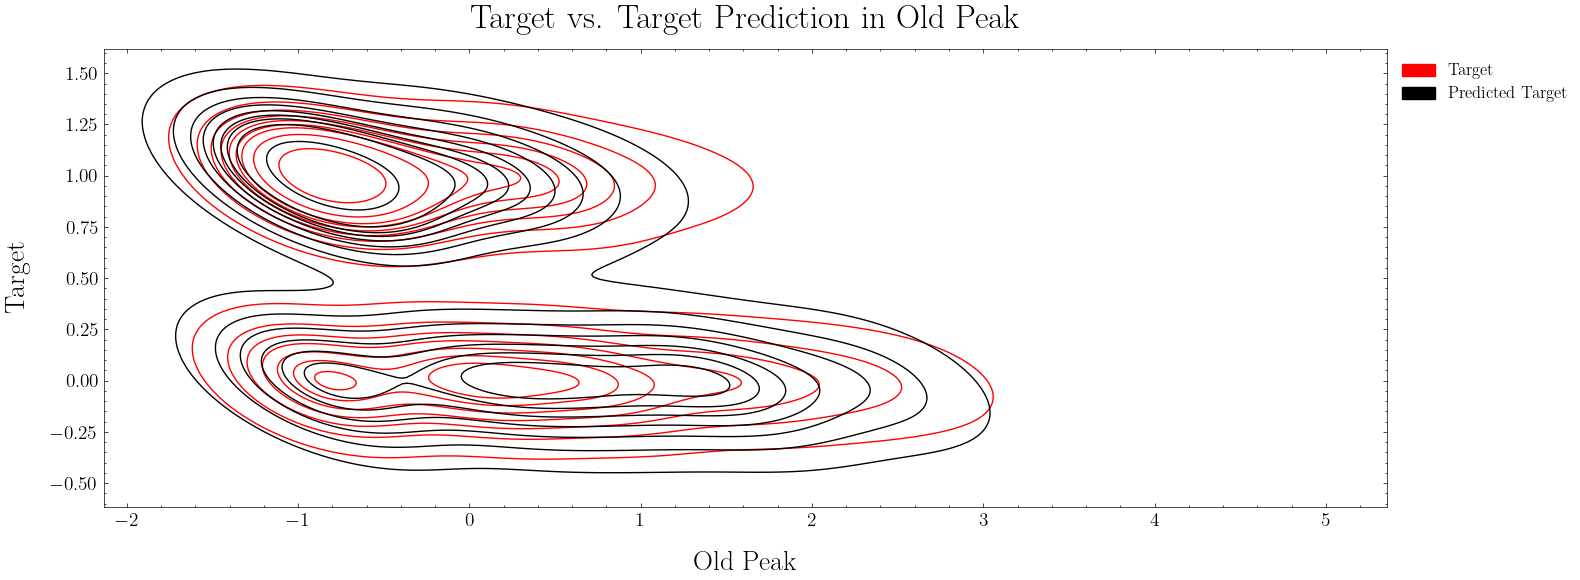

In [35]:
for x in numerical:
    figsize = (16, 6)
    fig, ax = plt.subplots(figsize=figsize)

    sns.kdeplot(
        data=df_train_lr_sm,
        x=x,
        y='target',
        color='red',
        label='Target',
        alpha=1,
        ax=ax
    )

    sns.kdeplot(
        data=df_test_lr_sm,
        x=x,
        y='target_prediction',
        color='black',
        label='Predicted Target',
        alpha=1,
        ax=ax
    )

    y = ax.yaxis.get_label().get_text()
    x = column_to_title(x)
    y = column_to_title(y)

    ax.set_xlabel(x)
    ax.set_ylabel(y)

    handles = [
        Patch(facecolor='red', edgecolor='red', label='Target'),
        Patch(facecolor='black', edgecolor='black', label='Predicted Target')
    ]
    
    ax.legend(
        handles=handles, 
        loc='upper left', 
        bbox_to_anchor=(1, 1)
    )
    
    ax.set_title('Target vs. Target Prediction in ' + x)

    plt.tight_layout()
    plt.show()
    plt.close()
    
    print('\n')

$$\text{\Large{Measure performance}}$$

In order to measure the performance of my model, I use a confusion matrix, accuracy, precision and recall scoring, plotting of the logistic regression coefficients, plotting the parameters for GridSearchCV, and permutation importance. The confusion matrix for this model is decent, because the model is able to identify the true negatives and positives, as indicated by the top left and bottom right cells respectively. However, there is still room for improvement due to the false negatives and positives as indicated by the bottom left and top right cells respectively. The range of accuracy, precision and recall scores seem to hover around 0.82 to 0.95

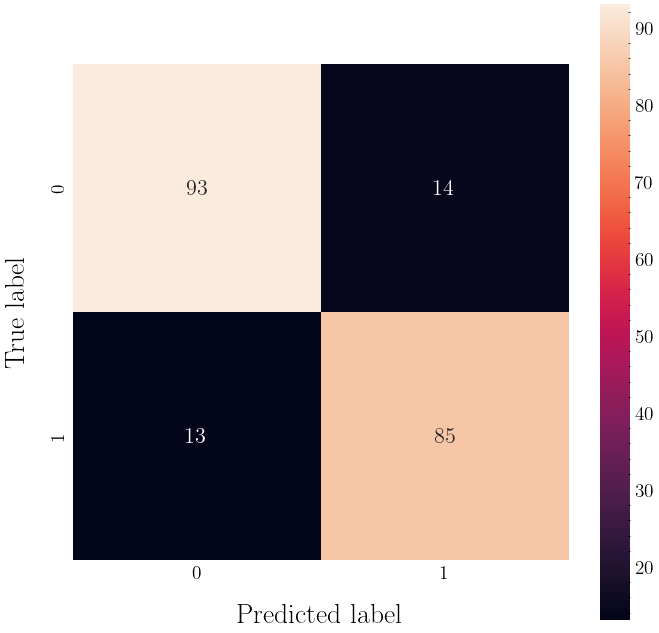

In [36]:
display_confusion_matrix(
    df_test_lr_sm['target'],
    df_test_lr_sm['target_prediction']
)

In [37]:
display_score(
    df_test_lr_sm['target'],
    df_test_lr_sm['target_prediction']
)

Accuracy: 0.87
Precision: 0.86
Recall: 0.87


In [38]:
count = df_heart.target.value_counts()
print(count)

target
1    526
0    499
Name: count, dtype: int64


In [39]:
x, y = count
score = x / (y + x)
print(f"Baseline for Naïve model: {score:.2f}")

Baseline for Naïve model: 0.51


$$\text{\Huge{Logistic Regression (sklearn)}}$$

$$\text{\Large{Data preprocessing}}$$

In [40]:
df_heart_regression

age  resting_blood_pressure  cholesterol  max_heart_rate  old_peak  \
0      52                     125          212             168       1.0   
1      53                     140          203             155       3.1   
2      70                     145          174             125       2.6   
3      61                     148          203             161       0.0   
4      62                     138          294             106       1.9   
...   ...                     ...          ...             ...       ...   
1020   59                     140          221             164       0.0   
1021   60                     125          258             141       2.8   
1022   47                     110          275             118       1.0   
1023   50                     110          254             159       0.0   
1024   54                     120          188             113       1.4   

      target  sex_female  sex_male  chest_pain_type_asymptomatic  \
0          0       False      True                         False   
1          0       False      True                         False   
2          0       False      True                         False   
3          0       False      True                         False   
4          0        True     False                         False   
...      ...         ...       ...                           ...   
1020       1       False      True                         False   
1021       0       False      True                         False   
1022       0       False      True                         False   
1023       1        True     False                         False   
1024       0       False      True                         False   

      chest_pain_type_atypical_angina  ...  rest_ecg_st_t_wave_abnormality  \
0                               False  ...                            True   
1                               False  ...                           False   
2                               False  ...                            True   
3                               False  ...                            True   
4                               False  ...                            True   
...                               ...  ...                             ...   
1020                             True  ...                            True   
1021                            False  ...                           False   
1022                            False  ...                           False   
1023                            False  ...                           False   
1024                            False  ...                            True   

      exercise_induced_angina_no  exercise_induced_angina_yes  \
0                           True                        False   
1                          False                         True   
2                          False                         True   
3                           True                        False   
4                           True                        False   
...                          ...                          ...   
1020                       False                         True   
1021                       False                         True   
1022                       False                         True   
1023                        True                        False   
1024                        True                        False   

      slope_downsloping  slope_flat  slope_upsloping  \
0                  True       False            False   
1                 False       False             True   
2                 False       False             True   
3                  True       False            False   
4                 False        True            False   
...                 ...         ...              ...   
1020               True       False            False   
1021              False        True            False   
1022              False        True            False  

In [41]:
X = df_heart_regression.drop('target', axis=1)
y = df_heart_regression['target']

X_train_lr_sk, X_test_lr_sk, y_train_lr_sk, y_test_lr_sk = train_test_split(X, y, test_size=0.20)

In [42]:
print(X_train_lr_sk.shape)
print(X_test_lr_sk.shape)

(820, 25)
(205, 25)


In [43]:
print(y_train_lr_sk.shape)
print(y_test_lr_sk.shape)

(820,)
(205,)


In [44]:
scaler = StandardScaler()

X_train_lr_sk[numerical] = scaler.fit_transform(X_train_lr_sk[numerical])
X_test_lr_sk[numerical] = scaler.transform(X_test_lr_sk[numerical])

$$\text{\Large{Build a model}}$$

In [45]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
max_iter = [i for i in range(100, 1000, 100)]

param_grid = {
    'C': C,
    'max_iter': max_iter,
}

search_lr_sk = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
)

search_lr_sk.fit(X_train_lr_sk, y_train_lr_sk)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 200, 300, 400, 500, 600, 700, 800,
                                      900]},
             return_train_score=True, scoring='accuracy')

In [46]:
df_score_lr_sk = pd.DataFrame(search_lr_sk.cv_results_)

for k, v in search_lr_sk.best_params_.items():
    print(f"{k}: {v}")

C: 0.1
max_iter: 100


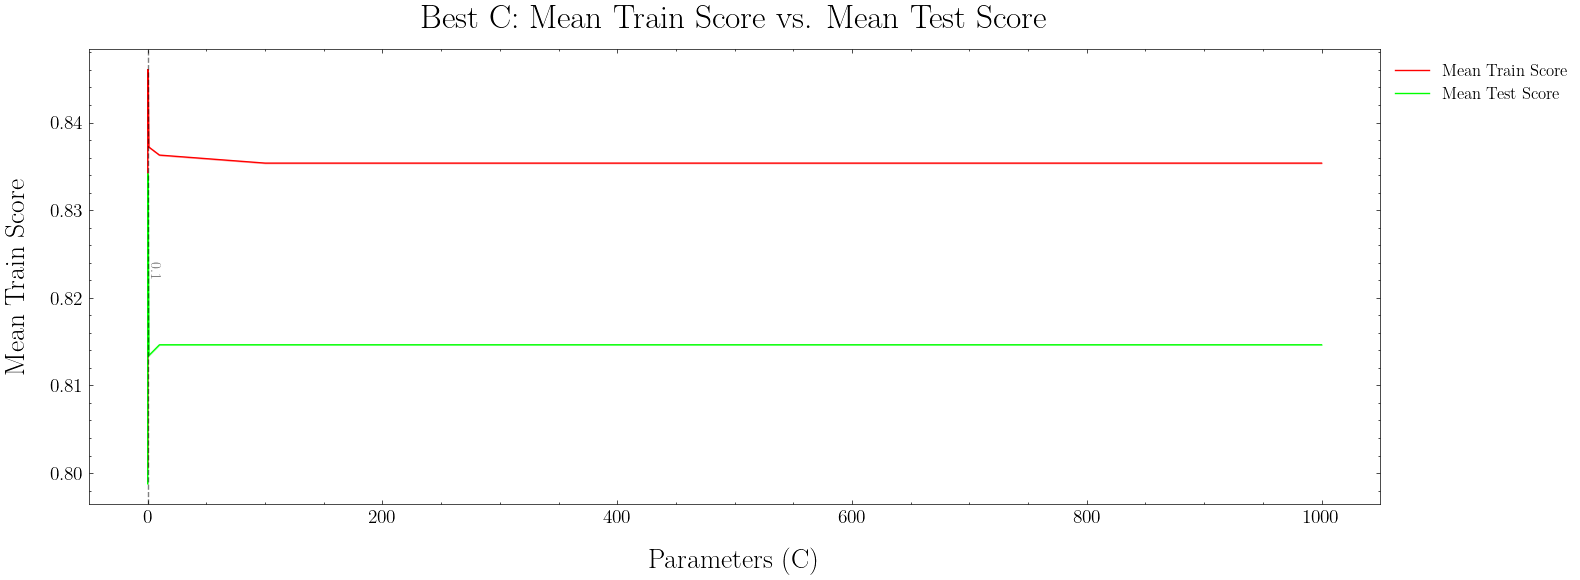

In [47]:
figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

train = 'mean_train_score'
test = 'mean_test_score'

sns.lineplot(
    data=df_score_lr_sk,
    x=df_score_lr_sk.param_C,
    y=train,
    label=column_to_title(train),
    color='red',
    ax=ax,
)

sns.lineplot(
    data=df_score_lr_sk,
    x=df_score_lr_sk.param_C,
    y=test,
    label=column_to_title(test),
    color='lime',
    ax=ax
)

x = search_lr_sk.best_params_.get('C')

transform = ax.get_xaxis_transform()
ax.axvline(x, alpha=0.50, color='black', linestyle='--')

plt.text(
    x,
    0.5,
    x,
    color='black',
    alpha=0.50,
    transform=transform,
    rotation=270
)

xlabel = ax.get_xlabel()
ylabel = ax.get_ylabel()

xlabel = column_to_title(xlabel)
ylabel = column_to_title(ylabel)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_title('Best C: Mean Train Score vs. Mean Test Score')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

In [48]:
df_score_lr_sk.nlargest(5, 'mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
18       0.003204      0.000749         0.001500        0.000447     0.1   
19       0.003803      0.000246         0.001205        0.000602     0.1   
20       0.003310      0.000404         0.001406        0.000376     0.1   
21       0.003912      0.000579         0.001000        0.000632     0.1   
22       0.003000      0.001097         0.001302        0.000246     0.1   

   param_max_iter                       params  split0_test_score  \
18            100  {'C': 0.1, 'max_iter': 100}           0.810976   
19            200  {'C': 0.1, 'max_iter': 200}           0.810976   
20            300  {'C': 0.1, 'max_iter': 300}           0.810976   
21            400  {'C': 0.1, 'max_iter': 400}           0.810976   
22            500  {'C': 0.1, 'max_iter': 500}           0.810976   

    split1_test_score  split2_test_score  ...  mean_test_score  \
18           0.859756           0.829268  ...         0.834146   
19           0.859756           0.829268  ...         0.834146   
20           0.859756           0.829268  ...         0.834146   
21           0.859756           0.829268  ...         0.834146   
22           0.859756           0.829268  ...         0.834146   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
18        0.017418                1            0.852134            0.841463   
19        0.017418                1            0.852134            0.841463   
20        0.017418                1            0.852134            0.841463   
21        0.017418                1            0.852134            0.841463   
22        0.017418                1            0.852134            0.841463   

    split2_train_score  split3_train_score  split4_train_score  \
18            0.839939            0.842988            0.853659   
19            0.839939            0.842988            0.853659   
20            0.839939            0.842988            0.853659   
21            0.839939            0.842988            0.853659   
22            0.839939            0.842988            0.853659   

    mean_train_score  std_train_score  
18          0.846037         0.005704  
19          0.846037         0.005704  
20          0.846037         0.005704  
21          0.846037         0.005704  
22          0.846037         0.005704  

[5 rows x 22 columns]

In [49]:
model_lr_sk = search_lr_sk.best_estimator_
model_lr_sk.fit(X_train_lr_sk, y_train_lr_sk)
y_pred_lr_sk = model_lr_sk.predict(X_test_lr_sk)

$$\text{\Large{Measure performance}}$$

In [50]:
display_score(
    y_test_lr_sk,
    y_pred_lr_sk
)

Accuracy: 0.85
Precision: 0.87
Recall: 0.83


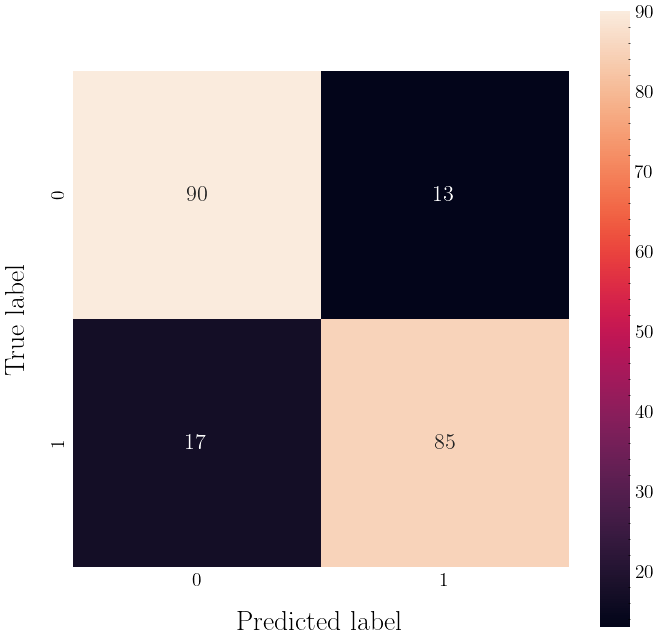

In [51]:
display_confusion_matrix(
    y_test_lr_sk,
    y_pred_lr_sk
)

In [52]:
pi = permutation_importance(
    model_lr_sk,
    X=X_test_lr_sk,
    y=y_test_lr_sk,
    scoring='accuracy',
    n_repeats=30
)

df_importance = pd.DataFrame(
    {
        'variable': X_test_lr_sk.columns,
        'importance': pi.importances_mean.round(4),
        'sd': pi.importances_std.round(4)
    }
)

df_importance.sort_values(by='importance', ascending=False)

positive_importance = df_importance[df_importance.importance > 0]
negative_importance = df_importance[df_importance.importance < 0]

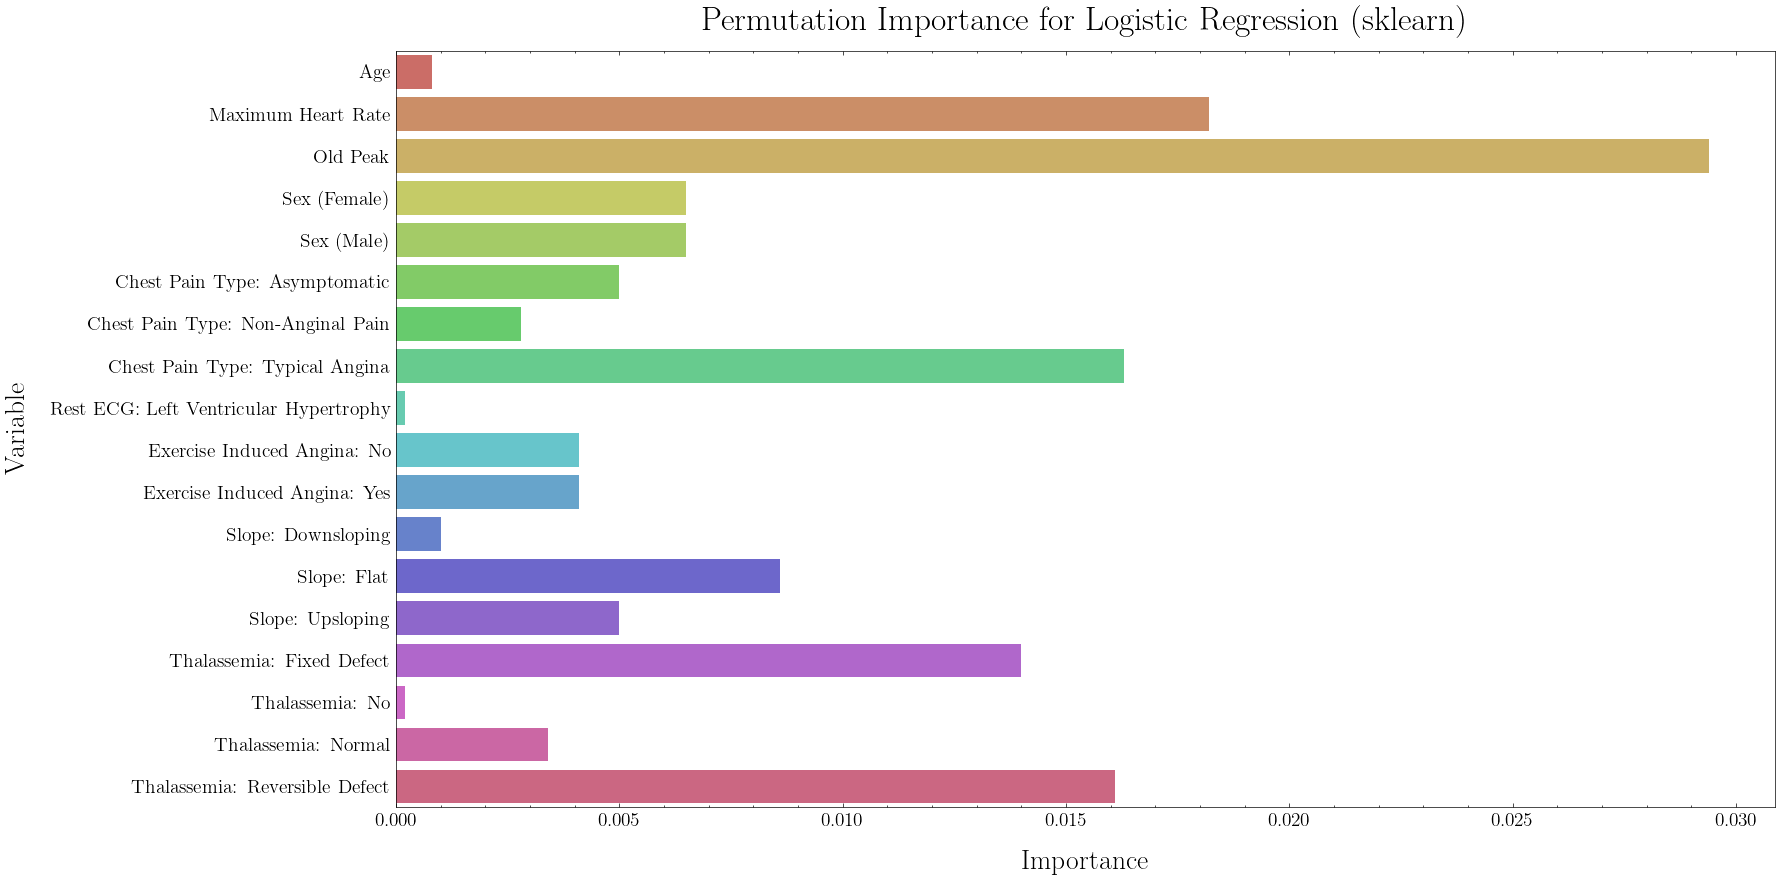

In [53]:
display_permutation_importance(positive_importance, name='Logistic Regression (sklearn)')

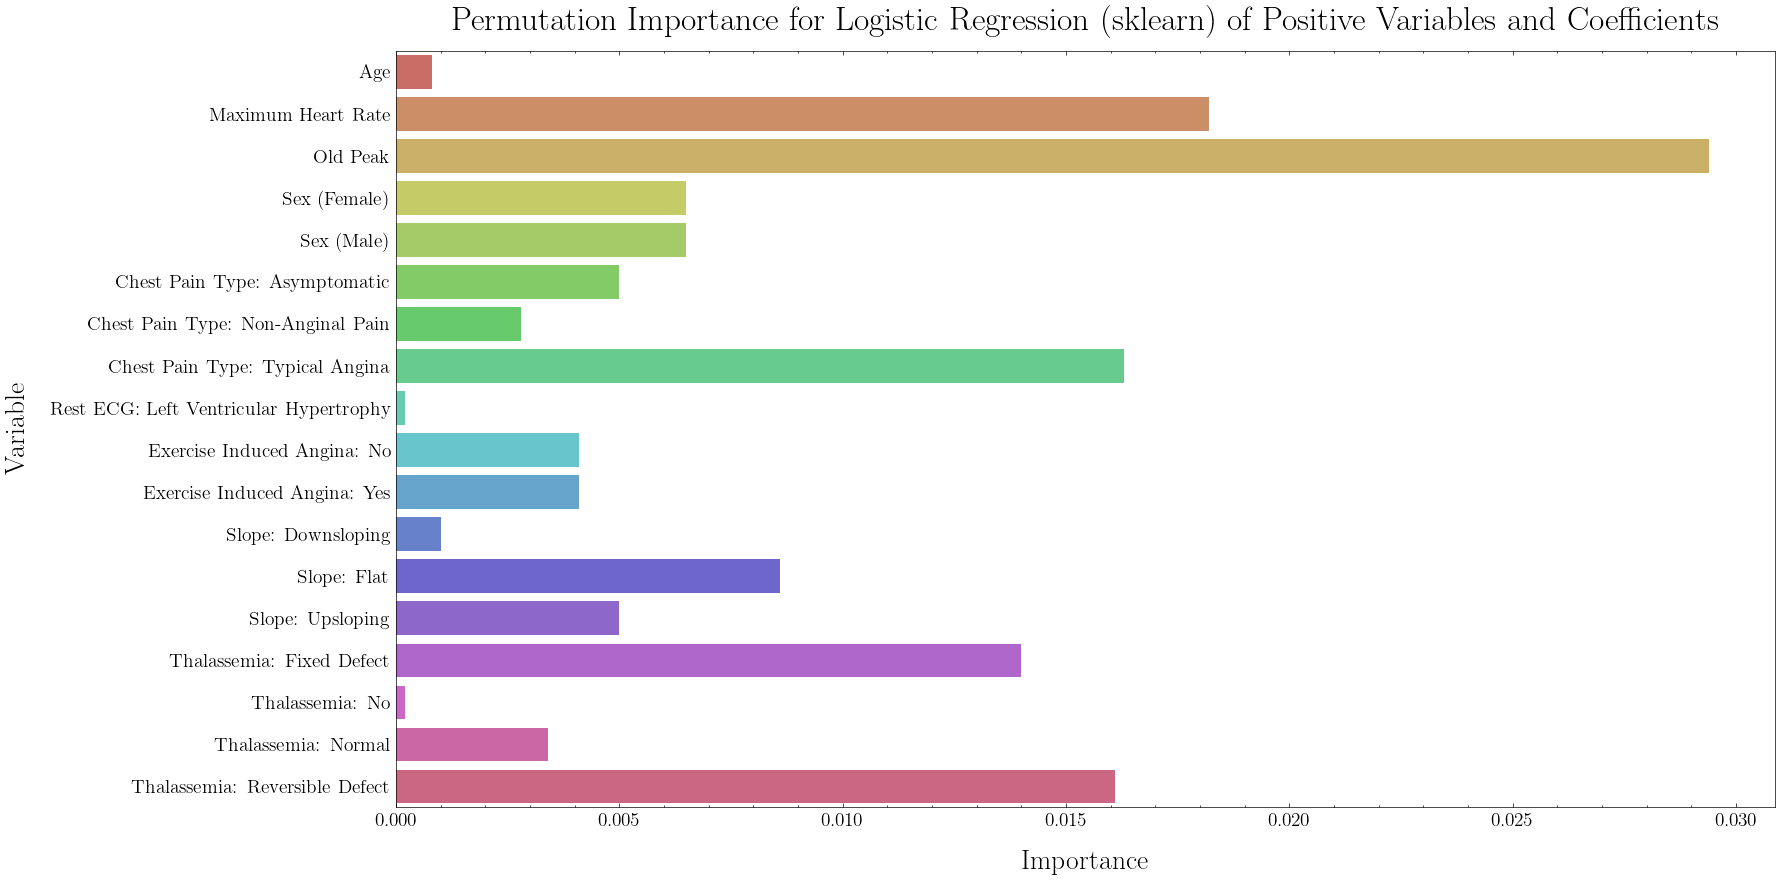

In [54]:
if not positive_importance.empty:
    display_permutation_importance(positive_importance, name='Logistic Regression (sklearn) of Positive Variables and Coefficients')

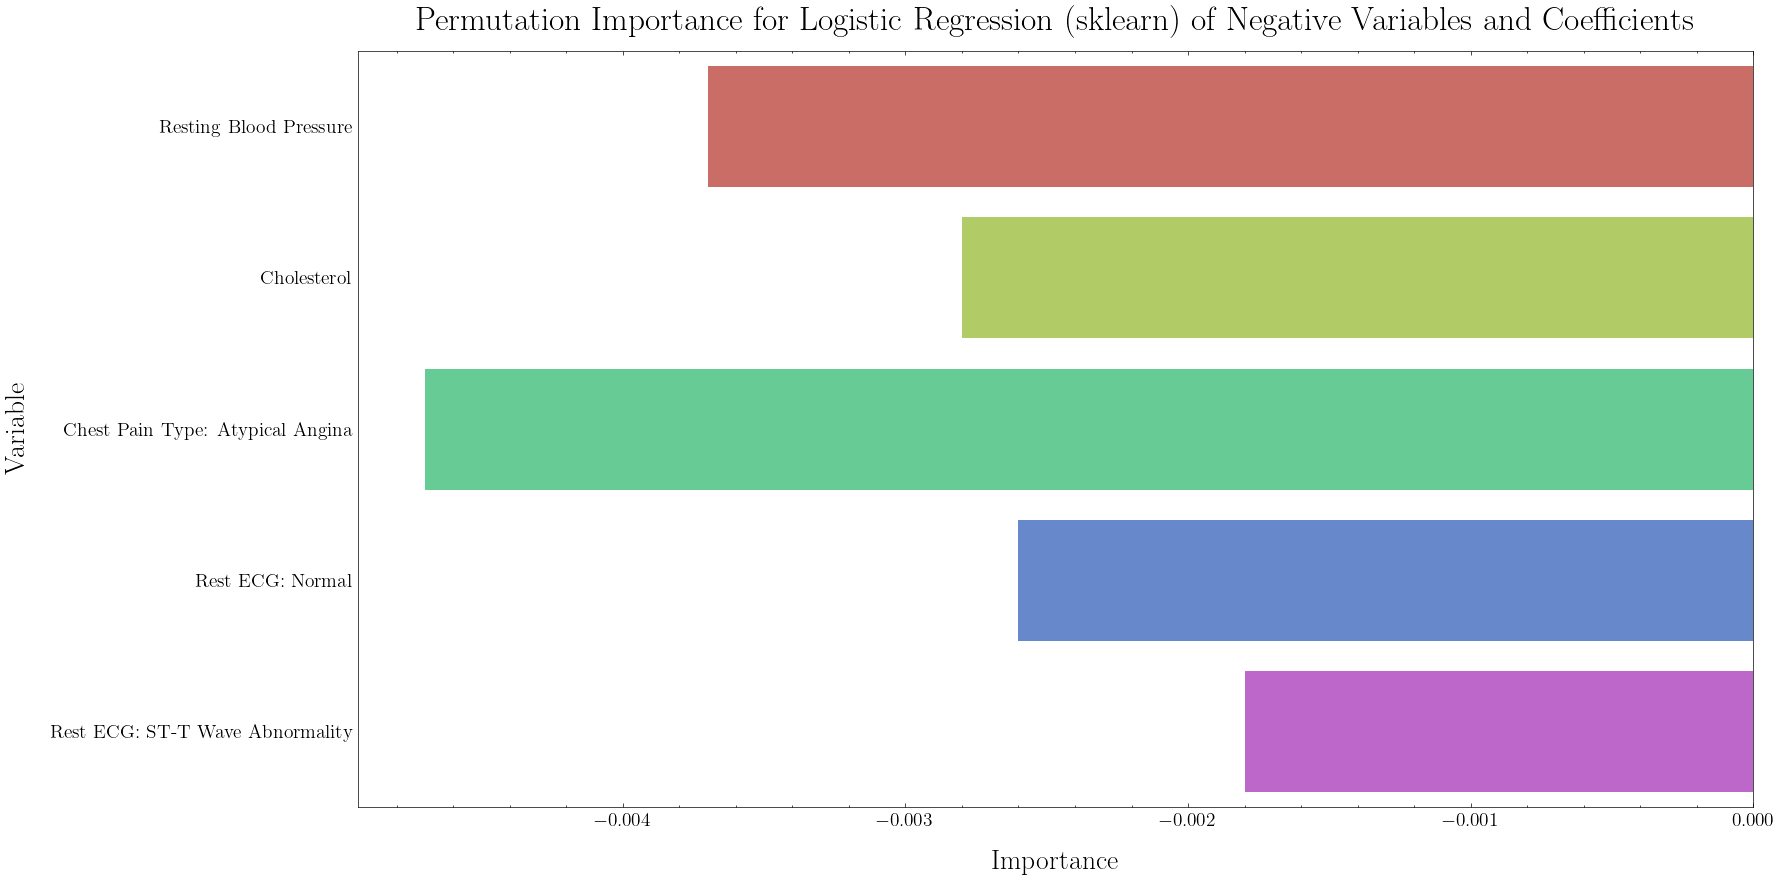

In [55]:
if not negative_importance.empty:
    display_permutation_importance(negative_importance, name='Logistic Regression (sklearn) of Negative Variables and Coefficients')

In [56]:
min_features_to_select = 1

rfecv = RFECV(
    estimator=model_lr_sk,
    step=1,
    cv=3,
    min_features_to_select=min_features_to_select
)

rfecv.fit(X_train_lr_sk, y_train_lr_sk)

RFECV(cv=3, estimator=LogisticRegression(C=0.1))

In [57]:
print(f"Optimal number of features : {rfecv.n_features_}")

Optimal number of features : 14


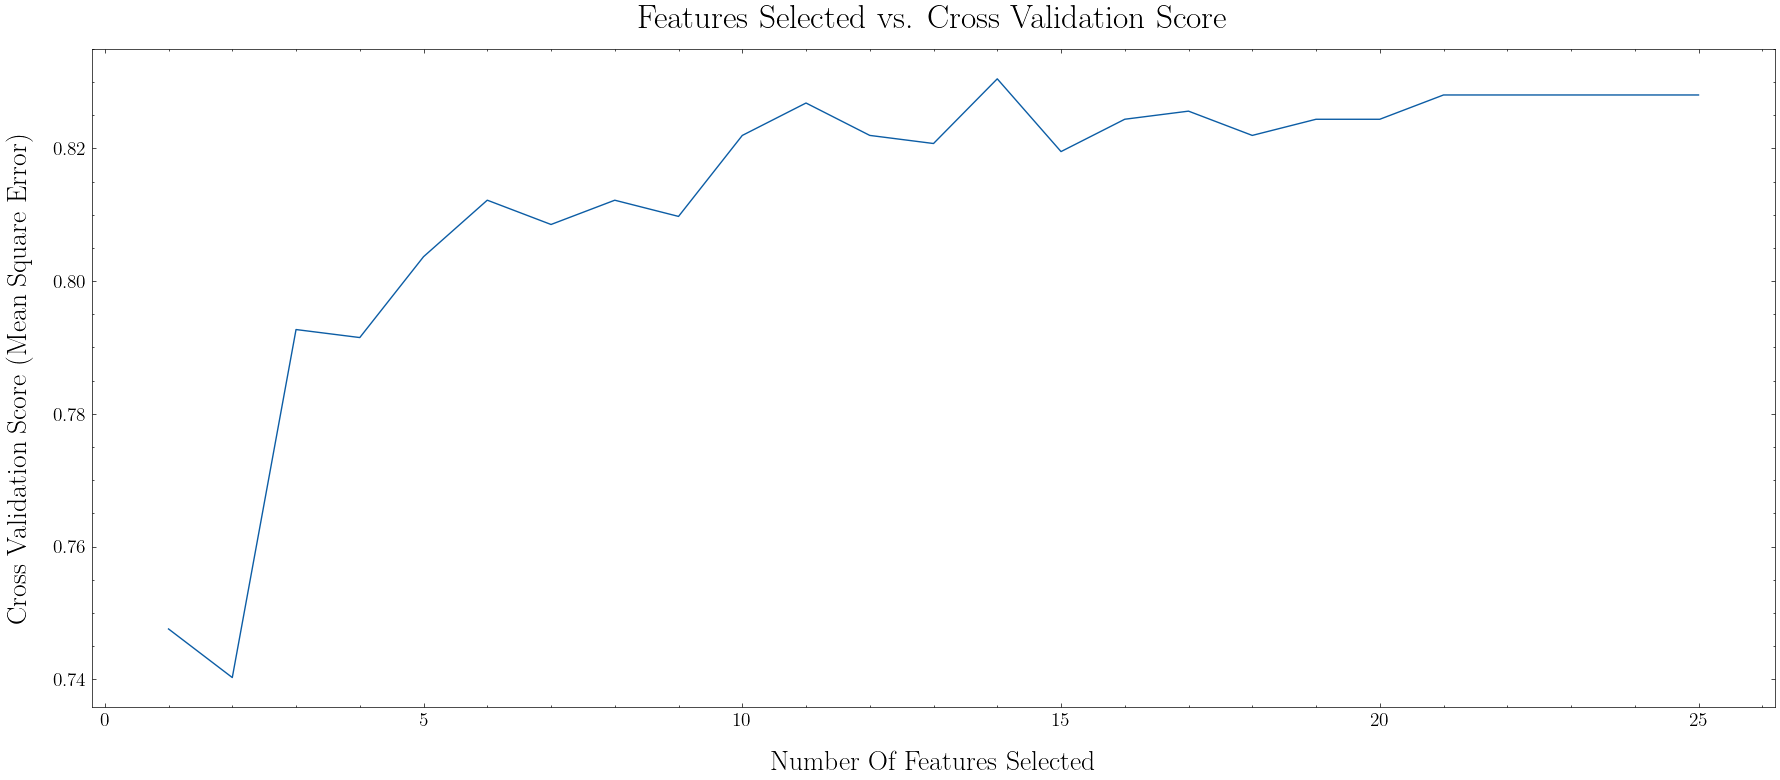

In [58]:
scores = rfecv.cv_results_['mean_test_score']

figsize = (18, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (mean square error)')

plt.plot(
    range(
        min_features_to_select,
        len(scores) + min_features_to_select
    ),
    scores
)

xlabel = ax.get_xlabel()
ylabel = ax.get_ylabel()

xlabel = column_to_title(xlabel)
ylabel = column_to_title(ylabel)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_title('Features Selected vs. Cross Validation Score')

plt.tight_layout()
plt.show()
plt.close()

In [59]:
rfecv.support_

array([ True, False, False,  True,  True,  True,  True,  True, False,
        True,  True, False, False, False, False,  True,  True,  True,
       False,  True, False,  True, False, False,  True])

In [60]:
X_train_lr_sk_reduced = X_train_lr_sk.iloc[:, rfecv.support_]
X_train_lr_sk_reduced.head(3)

age  max_heart_rate  old_peak  sex_female  sex_male  \
580 -0.918314        0.295526  -0.90736       False      True   
563 -1.137406        0.165147  -0.90736       False      True   
340 -1.794680        1.034343  -0.90736       False      True   

     chest_pain_type_asymptomatic  chest_pain_type_non_anginal_pain  \
580                         False                             False   
563                         False                             False   
340                         False                              True   

     chest_pain_type_typical_angina  rest_ecg_st_t_wave_abnormality  \
580                           False                            True   
563                            True                           False   
340                           False                            True   

     exercise_induced_angina_no  exercise_induced_angina_yes  slope_flat  \
580                        True                        False       False   
563                        True                        False       False   
340                        True                        False       False   

     thalassemia_fixed_defect  thalassemia_reversable_defect  
580                     False                           True  
563                      True                          False  
340                      True                          False

In [61]:
rfecv.estimator_.coef_

array([[-0.20847161,  0.34746028, -0.57776344,  0.55530843, -0.55474903,
         0.43050676,  0.41976437, -0.99069751,  0.31891454,  0.36910076,
        -0.36854136, -0.42287439,  0.52372579, -0.65164164]])

$$\text{\Huge{Discussion and interpretation}}$$

> What have you learnt about the ability to model and predict your variable of interest?

The outcome of my model(s) changed, depending on:
*   The parameters
*   The amount of times the notebook was executed
*   The features included or excluded

There were instances where the model would align with the initial data exploration and visualization, and put importance on variables that seemed to influence heart disease, such as: the female sex, zero vessels colored by flourosopy and a fixed defect for thalassemia. However, both the coefficient analysis and permutation importance seemed to fluctuate in subsequent attempts.

<br>

> What variables are responsible for the predictive ability of your model, and what does your model suggest about the relationships these variables have with your target variable?

The vessels that were colored by flourosopy seemed to be indicative of heart disease, which are presented in the initial data exploration of this notebook. The model also determined it to be an important factor in predicting heart disease. In most of my experiments, vessels colored by flourosopy seemed to weighted highly, regardless of parameters or repeated executions.

The sex of the patient would fluctuate in importance, but the model would consistently indicate that females were an important predictor, which also aligned with the original dataset.

There were a few consistent negative importances, but the most consistent variable seemed to be fasting blood sugar. In this dataset, each category in fasting blood sugar: "Lower than 120 mg/ml" and "Greater than 120 mg/ml" seemed to have same distribution of heart disease vs no heart disease. I wonder if that offset and affected the importance of it being a predictor? In my initial data exploration, the patients who had "Lower than 120 mg/ml" seemed to have a high risk of heart disease, but there was a comparable amount of people who did not have heart disease.

<br>

> How did these relationships generalize to the withheld sample (i.e., testing data sample)?

It generalized well in both statsmodels' `logit` model and sklearn's `LogisticRegression()` model. The introduction of more hyperparameters could boost the scores even more, however the time and computation required would increase, and it is too cumbersome on the free version of Google Colab. I am satisfied in the scoring/confusion matrix and permutation importance (of sklearn's model). In comparing the permutation importance plot(s) and the data exploration phase, it does a good job at predicting the important variables. Overall, I am content with the notebook, and excited to discover how to improve my data science skills in the future.

$$\text{\Huge{Bonus}}$$

$$\text{\LARGE{Decision Tree}}$$

$$\text{\Large{Data preprocessing}}$$

In [62]:
df_heart_tree = df_heart.copy()

# Create a dataframe of those features
df_target = df_heart_tree[['thalassemia']]

# Fit the scaler to those data
encoder = OrdinalEncoder()

# Use the scaler to transform your data
df_target = encoder.fit_transform(df_target.values)

# Put these scaled features back into your transformed features dataframe
df_heart_tree['thalassemia'] = df_target

# Take a look
df_heart_tree

age     sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0      52    Male   Typical angina                     125          212   
1      53    Male   Typical angina                     140          203   
2      70    Male   Typical angina                     145          174   
3      61    Male   Typical angina                     148          203   
4      62  Female   Typical angina                     138          294   
...   ...     ...              ...                     ...          ...   
1020   59    Male  Atypical angina                     140          221   
1021   60    Male   Typical angina                     125          258   
1022   47    Male   Typical angina                     110          275   
1023   50  Female   Typical angina                     110          254   
1024   54    Male   Typical angina                     120          188   

         fasting_blood_sugar               rest_ecg  max_heart_rate  \
0       Lower than 120 mg/ml  ST-T wave abnormality             168   
1     Greater than 120 mg/ml                 Normal             155   
2       Lower than 120 mg/ml  ST-T wave abnormality             125   
3       Lower than 120 mg/ml  ST-T wave abnormality             161   
4     Greater than 120 mg/ml  ST-T wave abnormality             106   
...                      ...                    ...             ...   
1020    Lower than 120 mg/ml  ST-T wave abnormality             164   
1021    Lower than 120 mg/ml                 Normal             141   
1022    Lower than 120 mg/ml                 Normal             118   
1023    Lower than 120 mg/ml                 Normal             159   
1024    Lower than 120 mg/ml  ST-T wave abnormality             113   

     exercise_induced_angina  old_peak        slope  \
0                         No       1.0  Downsloping   
1                        Yes       3.1    Upsloping   
2                        Yes       2.6    Upsloping   
3                         No       0.0  Downsloping   
4                         No       1.9         Flat   
...                      ...       ...          ...   
1020                     Yes       0.0  Downsloping   
1021                     Yes       2.8         Flat   
1022                     Yes       1.0         Flat   
1023                      No       0.0  Downsloping   
1024                      No       1.4         Flat   

      vessels_colored_by_flouroscopy  thalassemia  target  
0                                  2          3.0       0  
1                                  0          3.0       0  
2                                  0          3.0       0  
3                                  1          3.0       0  
4                                  3          0.0       0  
...                              ...          ...     ...  
1020                               0          0.0       1  
1021                               1          3.0       0  
1022                               1          0.0       0  
1023                               0          0.0       1  
1024                               1          3.0       0  

[1025 rows x 14 columns]

In [63]:
# Create dummy variables
feature = categorical.copy()
feature.remove('thalassemia')

df_features = pd.get_dummies(df_heart_tree[feature])

# Transform the column names to snakecase
df_features.columns = df_features.columns.str.lower()
df_features.columns = df_features.columns.str.replace(' ', '_')
df_features.columns = df_features.columns.str.replace('-', '_')
df_features.columns = df_features.columns.str.replace('/', '_')

# Add them back to the original dataframe
df_heart_tree = pd.concat(
    [df_heart_tree, df_features],
    axis=1
)

# Drop the old columns
df_heart_tree = df_heart_tree.drop(feature, axis=1)

# Take a look
df_heart_tree

age  resting_blood_pressure  cholesterol  max_heart_rate  old_peak  \
0      52                     125          212             168       1.0   
1      53                     140          203             155       3.1   
2      70                     145          174             125       2.6   
3      61                     148          203             161       0.0   
4      62                     138          294             106       1.9   
...   ...                     ...          ...             ...       ...   
1020   59                     140          221             164       0.0   
1021   60                     125          258             141       2.8   
1022   47                     110          275             118       1.0   
1023   50                     110          254             159       0.0   
1024   54                     120          188             113       1.4   

      thalassemia  target  sex_female  sex_male  chest_pain_type_asymptomatic  \
0             3.0       0       False      True                         False   
1             3.0       0       False      True                         False   
2             3.0       0       False      True                         False   
3             3.0       0       False      True                         False   
4             0.0       0        True     False                         False   
...           ...     ...         ...       ...                           ...   
1020          0.0       1       False      True                         False   
1021          3.0       0       False      True                         False   
1022          0.0       0       False      True                         False   
1023          0.0       1        True     False                         False   
1024          3.0       0       False      True                         False   

      ...  fasting_blood_sugar_greater_than_120_mg_ml  \
0     ...                                       False   
1     ...                                        True   
2     ...                                       False   
3     ...                                       False   
4     ...                                        True   
...   ...                                         ...   
1020  ...                                       False   
1021  ...                                       False   
1022  ...                                       False   
1023  ...                                       False   
1024  ...                                       False   

      fasting_blood_sugar_lower_than_120_mg_ml  \
0                                         True   
1                                        False   
2                                         True   
3                                         True   
4                                        False   
...                                        ...   
1020                                      True   
1021                                      True   
1022                                      True   
1023                                      True   
1024                                      True   

      rest_ecg_left_ventricular_hypertrophy  rest_ecg_normal  \
0                                     False            False   
1                                     False             True   
2                                     False            False   
3                                     False            False   
4                                     False            False   
...                                     ...              ...   
1020                                  False            False   
1021                                  False             True   
1022                                  False             True   
1023                                  False             True   
1024                                  False            False   

      rest_ecg_st_t_wave_abnormality  exercise_induced_angina_no 

In [64]:
# Split data into predictors (X) and target (y)
X = df_heart_tree.drop('thalassemia', axis=1)
y = df_heart_tree['thalassemia']

# Get the name of the features for the decision tree
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [65]:
print(X_train.shape)
print(X_test.shape)

(820, 22)
(205, 22)


In [66]:
print(y_train.shape)
print(y_test.shape)

(820,)
(205,)


In [67]:
# Create the standard scaler object
scaler = StandardScaler()

# Use this object to fit (i.e., to calculate the mean and std of each variable in the training data) and then to transform the training data
X_train[numerical] = scaler.fit_transform(X_train[numerical])

# Use the fit from the training data to transform the test data
X_test[numerical] = scaler.transform(X_test[numerical])

In [68]:
X_train

age  resting_blood_pressure  cholesterol  max_heart_rate  old_peak  \
271 -1.173461               -0.666526     0.318946        1.055425 -0.920078   
94   0.819897               -0.213145    -0.747044       -0.390421 -0.920078   
683 -1.284203               -0.666526    -1.347874       -1.266692  1.246428   
15  -2.280882               -0.779871    -0.708280        1.887883 -0.313456   
378  1.373607               -0.666526    -0.184976       -3.413556 -0.053476   
..        ...                     ...          ...             ...       ...   
787 -0.398266                0.466928     0.997303       -1.179065  2.719652   
803 -0.287524               -1.119907    -0.320648        0.485849 -0.920078   
302  0.044702                0.013546     1.850095        0.748731  0.119845   
593  0.930639               -1.346598     0.435236        0.880171  0.639806   
925  0.266186               -0.099799    -2.239429       -1.485760  0.119845   

     target  sex_female  sex_male  chest_pain_type_asymptomatic  \
271       1       False      True                         False   
94        1       False      True                         False   
683       0       False      True                         False   
15        1        True     False                         False   
378       0       False      True                         False   
..      ...         ...       ...                           ...   
787       0       False      True                         False   
803       0       False      True                         False   
302       1        True     False                         False   
593       0        True     False                         False   
925       0       False      True                         False   

     chest_pain_type_atypical_angina  ...  \
271                             True  ...   
94                              True  ...   
683                            False  ...   
15                              True  ...   
378                            False  ...   
..                               ...  ...   
787                            False  ...   
803                            False  ...   
302                             True  ...   
593                            False  ...   
925                            False  ...   

     fasting_blood_sugar_greater_than_120_mg_ml  \
271                                       False   
94                                         True   
683                                       False   
15                                        False   
378                                       False   
..                                          ...   
787                                       False   
803                                       False   
302                                       False   
593                                       False   
925                                       False   

     fasting_blood_sugar_lower_than_120_mg_ml  \
271                                      True   
94                                      False   
683                                      True   
15                                       True   
378                                      True   
..                                        ...   
787                                      True   
803                                      True   
302                                      True   
593                                      True   
925                                      True   

     rest_ecg_left_ventricular_hypertrophy  rest_ecg_normal  \
271                                  False            False   
94                                   False             True   
683                                  False             True   
15                                   False            False   
378                                  False            False   
..                                     ...              ...   
787                                  False            False 

In [69]:
X_test

age  resting_blood_pressure  cholesterol  max_heart_rate  old_peak  \
673  -0.066040               -0.666526     0.222038       -0.083727 -0.573437   
1    -0.176782                0.466928    -0.843952        0.266782  1.766390   
753   1.152123               -0.666526    -1.347874       -0.390421 -0.573437   
800   1.373607               -0.666526    -0.340029       -0.872370  1.333088   
1005  0.044702               -0.213145    -0.805188       -0.828557  0.813127   
...        ...                     ...          ...             ...       ...   
440   0.819897                1.033654    -0.049305        0.222968  0.293165   
504  -0.841235               -1.346598    -0.068687        0.135341 -0.920078   
1002  1.262865               -1.119907    -0.669517       -0.740930 -0.833418   
769   1.816576               -1.233253     0.357709       -0.828557 -0.920078   
826  -1.394945               -0.099799    -1.289729        0.047714 -0.920078   

      target  sex_female  sex_male  chest_pain_type_asymptomatic  \
673        1       False      True                         False   
1          0       False      True                         False   
753        1       False      True                         False   
800        0       False      True                         False   
1005       0        True     False                         False   
...      ...         ...       ...                           ...   
440        0        True     False                         False   
504        0       False      True                         False   
1002       0       False      True                         False   
769        1        True     False                         False   
826        1       False      True                         False   

      chest_pain_type_atypical_angina  ...  \
673                             False  ...   
1                               False  ...   
753                             False  ...   
800                             False  ...   
1005                            False  ...   
...                               ...  ...   
440                             False  ...   
504                             False  ...   
1002                            False  ...   
769                             False  ...   
826                             False  ...   

      fasting_blood_sugar_greater_than_120_mg_ml  \
673                                        False   
1                                           True   
753                                        False   
800                                        False   
1005                                       False   
...                                          ...   
440                                        False   
504                                        False   
1002                                       False   
769                                         True   
826                                        False   

      fasting_blood_sugar_lower_than_120_mg_ml  \
673                                       True   
1                                        False   
753                                       True   
800                                       True   
1005                                      True   
...                                        ...   
440                                       True   
504                                       True   
1002                                      True   
769                                      False   
826                                       True   

      rest_ecg_left_ventricular_hypertrophy  rest_ecg_normal  \
673                                   False             True   
1                                     False             True   
753                                   False            False   
800                                   False             True   
1005                                   True            False   
...                                     ...              .

$$\text{\Large{Build a model}}$$

In [70]:
# 1. Build the algorithm
classifier = DecisionTreeClassifier()

# 2. Fit the algorithm to the data
classifier_res = classifier.fit(X_train, y_train)

# 3. Make predictions
y_pred = classifier.predict(X_test)

$$\text{\Large{Measure performance}}$$

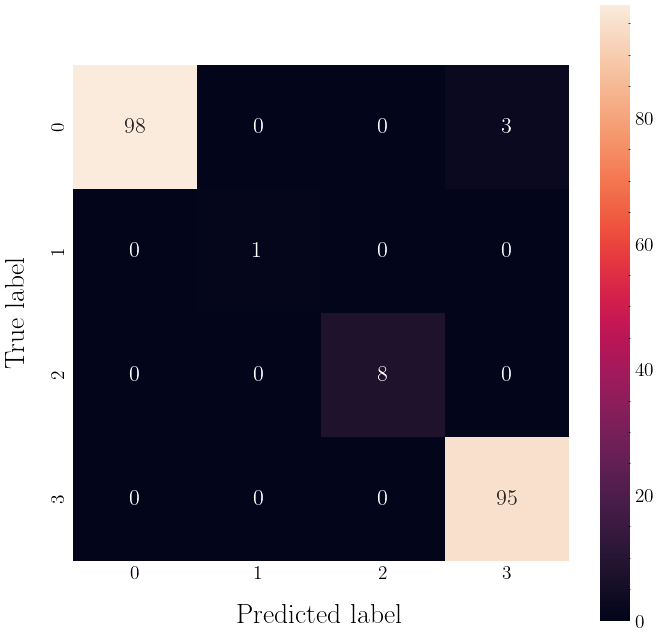

In [71]:
display_confusion_matrix(y_test, y_pred)

In [72]:
display_score(y_test, y_pred, average='micro')

Accuracy: 0.99
Precision: 0.99
Recall: 0.99


$$\text{\Large{Tuning hyperparameters}}$$

In [73]:
estimator = DecisionTreeClassifier()

max_depth = [i for i in range(1, 25)]
min_samples_split = [i for i in range(2, 25)]
criterion = ['gini', 'entropy']

param_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'criterion': criterion
}

grid = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy'
)

result = grid.fit(X_train, y_train)

df_score = pd.DataFrame(grid.cv_results_)

In [74]:
for k, v in grid.best_params_.items():
    print(f"{k}: {v}")

criterion: gini
max_depth: 17
min_samples_split: 2


In [75]:
df_score.nlargest(5, 'mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
368       0.002905      0.000373         0.001502        0.000448   
414       0.002884      0.000345         0.001420        0.000589   
874       0.003706      0.000399         0.001202        0.000247   
299       0.002804      0.000246         0.001501        0.000446   
345       0.004110      0.001330         0.001201        0.000749   

    param_criterion param_max_depth param_min_samples_split  \
368            gini              17                       2   
414            gini              19                       2   
874         entropy              15                       2   
299            gini              14                       2   
345            gini              16                       2   

                                                params  split0_test_score  \
368  {'criterion': 'gini', 'max_depth': 17, 'min_sa...           0.981707   
414  {'criterion': 'gini', 'max_depth': 19, 'min_sa...           0.975610   
874  {'criterion': 'entropy', 'max_depth': 15, 'min...           0.993902   
299  {'criterion': 'gini', 'max_depth': 14, 'min_sa...           0.969512   
345  {'criterion': 'gini', 'max_depth': 16, 'min_sa...           0.981707   

     split1_test_score  split2_test_score  split3_test_score  \
368           0.969512           0.987805           0.969512   
414           0.969512           0.987805           0.969512   
874           0.981707           0.969512           0.975610   
299           0.969512           0.987805           0.969512   
345           0.969512           0.975610           0.969512   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
368           0.993902         0.980488        0.009756                1  
414           0.993902         0.979268        0.009907                2  
874           0.975610         0.979268        0.008271                2  
299           0.993902         0.978049        0.010631                4  
345           0.993902         0.978049        0.009126                4

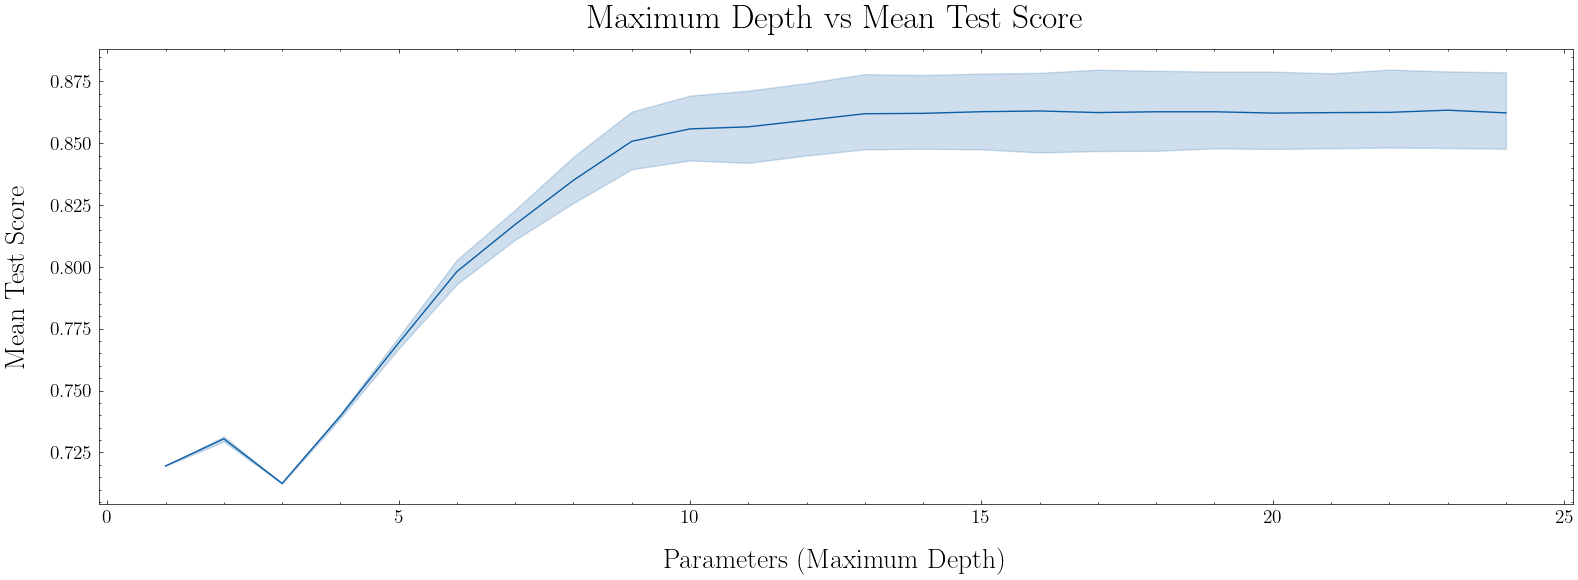

In [76]:
figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

sns.lineplot(
    data=df_score,
    x='param_max_depth',
    y='mean_test_score',
)

xlabel = ax.get_xlabel()
ylabel = ax.get_ylabel()

xlabel = column_to_title(xlabel)
ylabel = column_to_title(ylabel)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_title('Maximum Depth vs Mean Test Score')

plt.tight_layout()
plt.show()
plt.close()

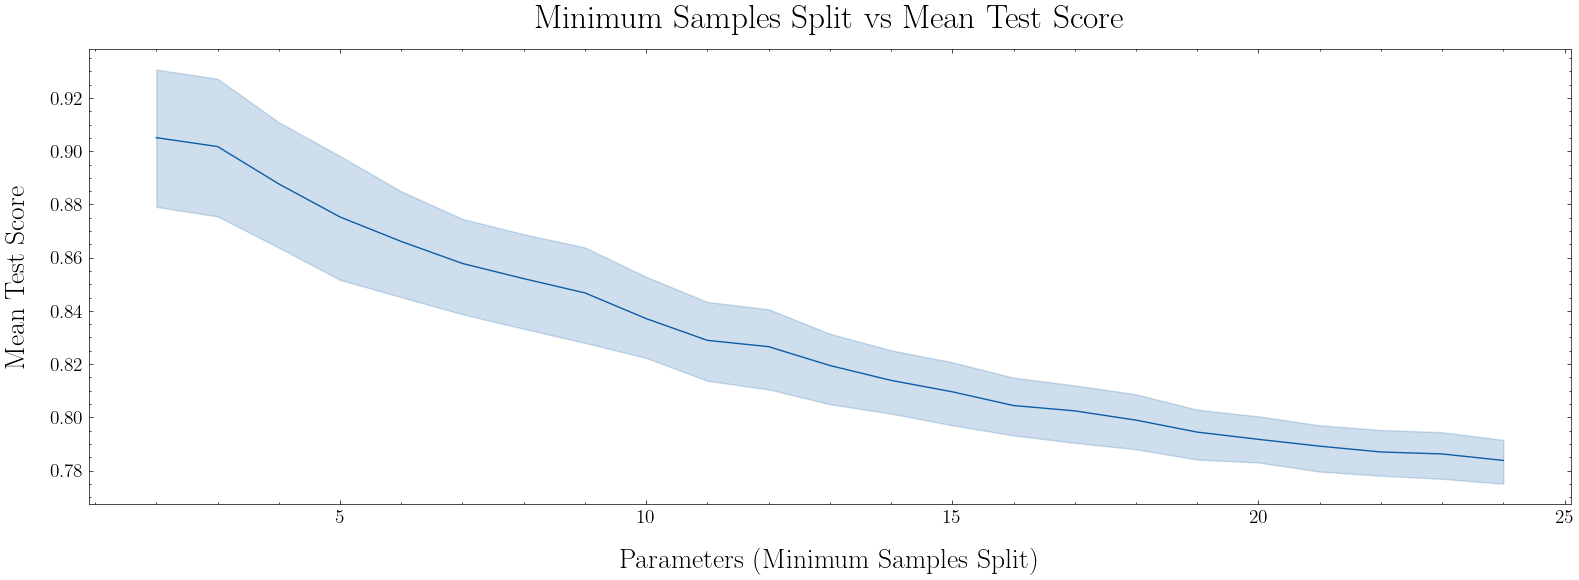

In [77]:
figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

sns.lineplot(
    data=df_score,
    x='param_min_samples_split',
    y='mean_test_score',
)

xlabel = ax.get_xlabel()
ylabel = ax.get_ylabel()

xlabel = column_to_title(xlabel)
ylabel = column_to_title(ylabel)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_title('Minimum Samples Split vs Mean Test Score')

plt.tight_layout()
plt.show()
plt.close()

In [78]:
# 1. Build the algorithm
estimator = result.best_estimator_

# 2. Fit the algorithm to the data
estimator_res = estimator.fit(X_train, y_train)

# 3. Make predictions
y_pred = estimator.predict(X_test)

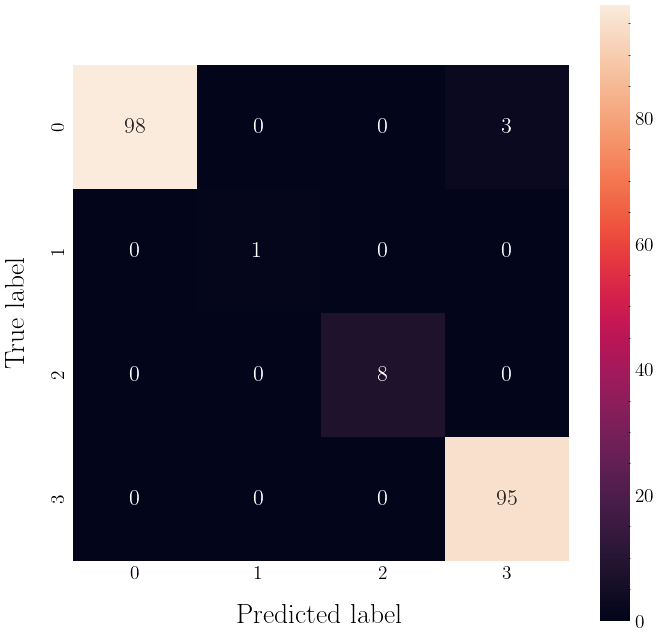

In [79]:
display_confusion_matrix(y_test, y_pred)

In [80]:
display_score(y_test, y_pred, average='micro')

Accuracy: 0.99
Precision: 0.99
Recall: 0.99


$$\text{\Large{Plotting}}$$

In [81]:
df_heart_tree['thalassemia'].value_counts()

thalassemia
0.0    544
3.0    410
2.0     64
1.0      7
Name: count, dtype: int64

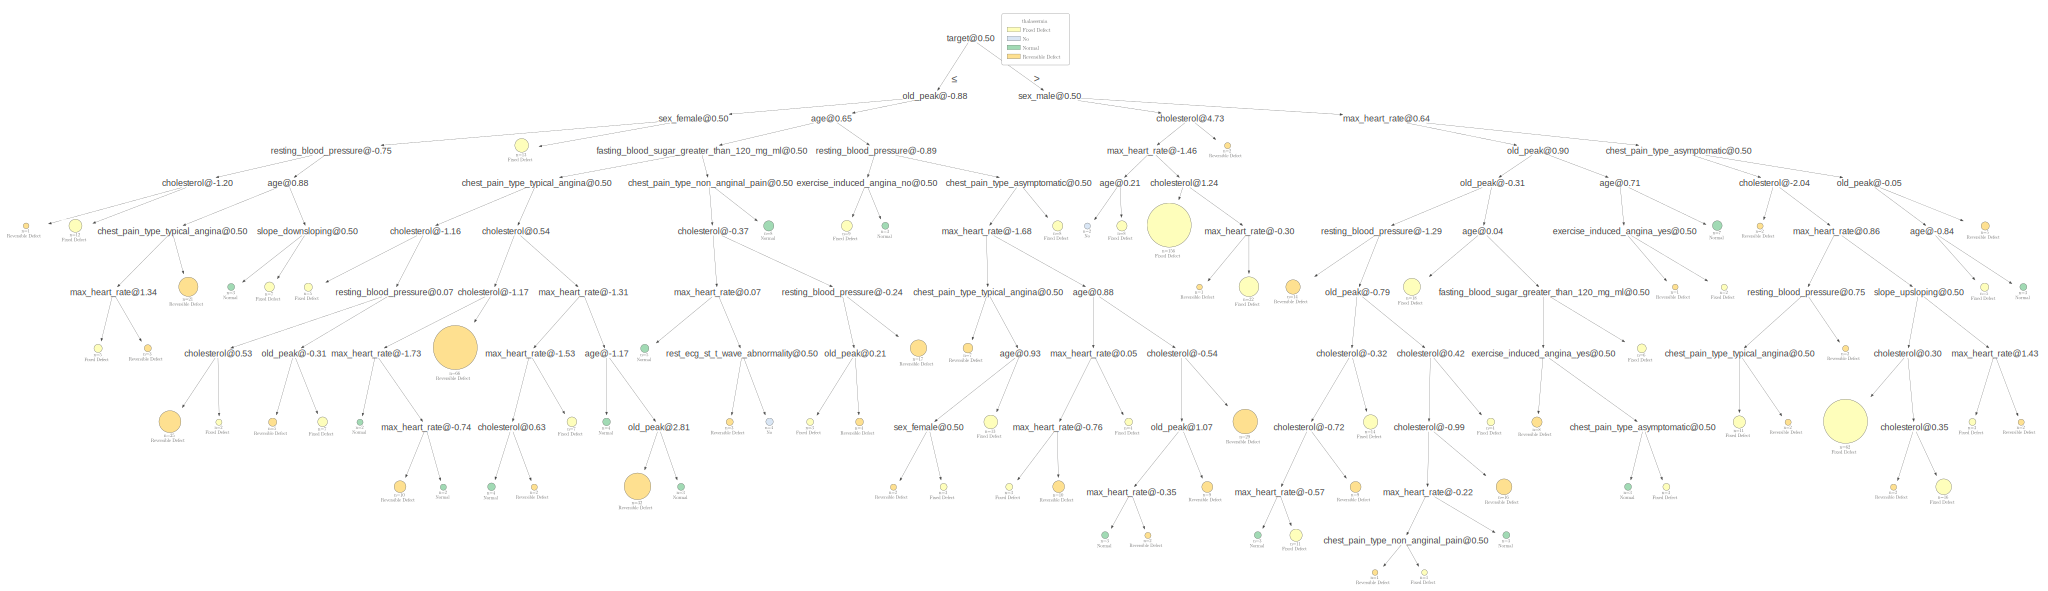

In [82]:
key = df_heart_tree['thalassemia'].unique().astype(int).tolist()
key.sort()

value = ['Fixed Defect', 'No', 'Normal', 'Reversible Defect']
value.sort()

length = len(key)

class_names = {
    int(key[i]): value[i]
    for i in range(length)
}

# Suppress warnings
warnings.filterwarnings('ignore')

# Build the figure using dtreeviz
tree = dtreeviz.model(
    estimator_res,
    X_train,
    y_train.astype(int),
    target_name='thalassemia',
    feature_names=feature_names,
    class_names=class_names
)

tree.view(fancy=False)